# 전체 데이터 작업 

In [1]:
# import 해주기
from glob import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pickle
import warnings
warnings.filterwarnings(action='ignore')
import gzip

from matplotlib import font_manager
# 한글설정(MAC)
# f_path = '/Library/Fonts/NanumGothic.ttf'
# font_manager.FontProperties(fname=f_path).get_name()
# from matplotlib import rc
# rc('font', family = 'NanumGothic')

# #(한글 설정 WIN)
from matplotlib import rc
plt.rcParams['axes.unicode_minus'] = False
f_path= "C:/Windows/Fonts/malgun.ttf"
font_name= font_manager.FontProperties(fname=f_path).get_name()
rc('font', family =font_name)
plt.rc('font', family='Malgun Gothic')

import folium
from folium.plugins import MarkerCluster, MiniMap

pd.options.display.float_format = '{:.5f}'.format

In [2]:
# # 피클 저장하기 

# with open('jeju_all.pickle','wb') as fw:
#     pickle.dump(jeju_all, fw)

In [3]:
# 피클 불러오기 

with open('jeju_all.pickle','rb') as fr:
    jeju_all = pickle.load(fr)

jeju_all.tail(3)

,OBJECTID,Field1,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,lon,lat,lon_lat,dong,Category
280082,278935,278935,202008,제주특별자치도,서귀포시,영세,예체능학원,x시,110000,0,1,0,921003.98200,1476177.84050,126.65174159048293,33.27407883370635,126.65174159048293_33.27407883370635,남원읍,교육/육아
280083,279538,279538,202008,제주특별자치도,서귀포시,영세,기타가구,x시,50000,0,1,0,937500.16740,1486052.75280,126.82818252032293,33.36422597166203,126.82818252032293_33.36422597166203,성산읍,생활/기타
280084,279785,279785,202008,제주특별자치도,제주시,영세,기타숙박업,x시,17470,0,2,0,941114.05310,1503713.22230,126.86586853032782,33.52371304945294,126.86586853032782_33.52371304945294,구좌읍,여행/숙박


In [4]:
# Time에 '시'를 제거해 줍니다.
jeju_all['Time']= jeju_all['Time'].str.replace('시', '')

# 시간을 큰 범위로 변화해 줍니다.
def time_cut(x):
    if '06'> x >='02':
        return '새벽'
    elif '11'> x >= '06':
        return '오전'
    elif '15' > x >= '11':
        return '점심'
    elif '18' > x >= '15':
        return '오후'
    elif  '22'> x >= '18':
        return '저녁'
    else:
        return '심야'

In [5]:
# 함수 적용
jeju_all['Time_cut'] = jeju_all['Time'].apply(time_cut)

jeju_all.loc[jeju_all['Time']=='x', 'Time_cut'] ='무승인거래'

# 1. 제주도 소비 전반적 분석  

In [6]:
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns 

<AxesSubplot:xlabel='Category', ylabel='TotalSpent'>

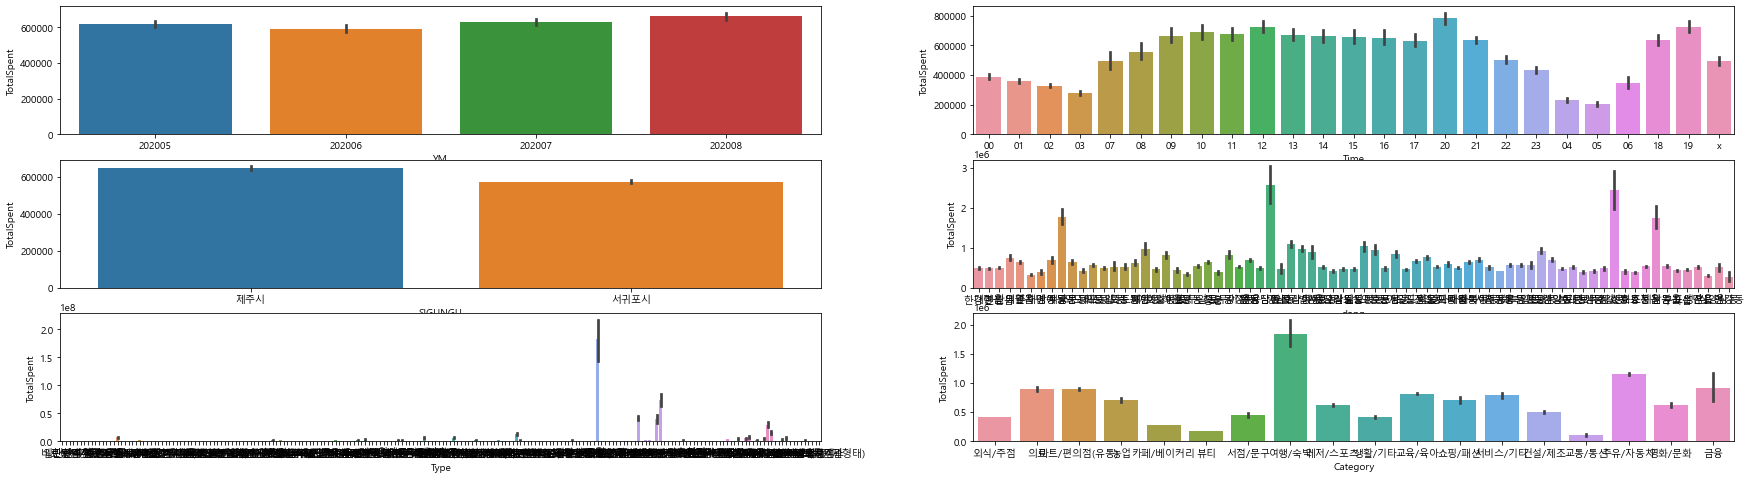

In [7]:
# 총사용금액로 각 컬럼별 데이터 스키밍 

figure, ((ax1,ax2), (ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(30,8)

sns.barplot(data=jeju_all, x="YM", y="TotalSpent", ax=ax1)  #월별 총사용금액 
sns.barplot(data=jeju_all, x="Time", y="TotalSpent", ax=ax2)  #시간대별 총 사용금액 
sns.barplot(data=jeju_all, x="SIGUNGU", y="TotalSpent", ax=ax3) #제주/서귀포 총 사용금액
sns.barplot(data=jeju_all, x="dong", y="TotalSpent", ax=ax4) # 읍면동별 총 사용금액 
sns.barplot(data=jeju_all, x="Type", y="TotalSpent", ax=ax5) # 업종별 사용금액 
sns.barplot(data=jeju_all, x="Category", y="TotalSpent", ax=ax6) # 업종구분별 사용금액 

In [8]:
def df_time(b,c):
    """
    b는 DisSpent or TotalSpent
    c는 시간을 문자열로
    """
    df_temp= jeju_all.groupby(['Time','Type'])[b].sum()
    df_temp=pd.DataFrame(df_temp).sort_values(b, ascending=False)
    df_temp.reset_index(inplace=True)
    return df_temp[df_temp['Time']==c].reset_index().head(10)

In [9]:
# 전체 시간별, 제주도 업종별 상위 10개 총사용금액을 보여줌(총사용금액)

df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('TotalSpent', i)
        df_total.append(df_temp)
    else:
        df_temp = df_time('TotalSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent
0,00,일반한식,1677964446,01,유흥주점,1249479291,02,유흥주점,1007309043,03,유흥주점,653158048,04,유흥주점,379003070,05,편의점,361632160,06,편의점,747650198,07,주유소,1433628112,08,주유소,1967525272,09,유아원,2480693770,10,슈퍼마켓,2724037069,11,일반한식,5573935461,12,일반한식,12985457998,13,일반한식,10097859576,14,일반한식,6669065245,15,일반한식,4271768026,16,슈퍼마켓,4569263198,17,슈퍼마켓,5004479365,18,일반한식,9019257495,19,일반한식,15920911731,20,일반한식,17576860695,21,일반한식,10154166066,22,일반한식,4716514394,23,일반한식,2719021765
1,00,유흥주점,1377319834,01,일반한식,1067636731,02,일반한식,678892520,03,일반한식,435681960,04,편의점,252701189,05,유흥주점,205036410,06,주유소,684430334,07,편의점,1183994930,08,슈퍼마켓,1388544035,09,주유소,2286527782,10,유아원,2685803080,11,슈퍼마켓,2760287062,12,서양음식,2866544773,13,슈퍼마켓,3040643477,14,슈퍼마켓,3435110556,15,슈퍼마켓,3890163693,16,면세점,3566947245,17,일반한식,4355495798,18,슈퍼마켓,5073070850,19,슈퍼마켓,4171381561,20,슈퍼마켓,3381237681,21,편의점,3244907749,22,편의점,2571743018,23,편의점,1757832755
2,00,편의점,1069768561,01,단란주점,749281631,02,단란주점,514091710,03,편의점,317351210,04,일반한식,233843823,05,일반한식,170665661,06,면세점,374592550,07,면세점,1048981340,08,편의점,1360138660,09,슈퍼마켓,2265661918,10,일반한식,2559795563,11,주유소,2473699690,12,슈퍼마켓,2838139019,13,서양음식,2923637873,14,면세점,2820576875,15,면세점,3255753865,16,일반한식,3190884842,17,면세점,2916795642,18,편의점,2652127052,19,편의점,2890278696,20,편의점,3285128081,21,슈퍼마켓,2758434393,22,슈퍼마켓,1725070706,23,유흥주점,1341605578
3,00,단란주점,830214940,01,편의점,679859251,02,편의점,460379818,03,단란주점,221701567,04,단란주점,84479600,05,주유소,148038414,06,골프경기장,328863860,07,슈퍼마켓,766076990,08,면세점,1357449480,09,면세점,1689285439,10,주유소,2433437286,11,면세점,2323183870,12,면세점,2819389960,13,면세점,2710893593,14,서양음식,2668575162,15,주유소,2596786432,16,주유소,2667311935,17,주유소,2659452937,18,주유소,2412772204,19,면세점,2334286847,20,일식회집,2093558089,21,일식회집,1499453688,22,유흥주점,994644534,23,단란주점,824573615
4,00,주점,509761373,01,주점,341764534,02,주점,202897286,03,주점,85962917,04,주유소,68082098,05,슈퍼마켓,82875930,06,일반한식,282537588,07,일반한식,515848481,08,일반한식,850813399,09,일반한식,1550875385,10,면세점,2042548965,11,유아원,2080548570,12,주유소,2356295666,13,주유소,2507035494,14,주유소,2591290597,15,서양음식,2242257603,16,농축협직영매장,2066114416,17,농축협직영매장,2297488453,18,면세점,2368435390,19,서양음식,1878253901,20,면세점,1922705276,21,대형할인점,1230357130,22,서양음식,749275593,23,주점,665867091
5,00,서양음식,321363660,01,서양음식,198590170,02,서양음식,108812830,03,기타숙박업,61122316,04,슈퍼마켓,46345350,05,콘도,51709954,06,슈퍼마켓,249946350,07,골프경기장,486726393,08,유아원,798452610,09,약국,1345630484,10,종합병원,1734857960,11,약국,1642855336,12,골프경기장,2291905588,13,골프경기장,1982682489,14,편의점,1758078300,15,편의점,1859714310,16,편의점,1960194672,17,편의점,2172893751,18,농축협직영매장,2201327840,19,농축협직영매장,1662807450,20,서양음식,1802888783,21,서양음식,1173035696,22,대형할인점,744883620,23,슈퍼마켓,589317316
6,00,인터넷Mall,240513708,01,인터넷Mall,134106140,02,기타숙박업,87150953,03,서양음식,58335890,04,기타숙박업,43602805,05,단란주점,42631100,06,화물운송,115414340,07,유아원,195756820,08,농축협직영매장,535898508,09,편의점,1284002320,10,약국,1649190081,11,서양음식,1627999470,12,편의점,1864684715,13,유아원,1819731050,14,유아원,1683167060,15,농축협직영매장,1786973112,16,대형할인점,1806708670,17,골프경기장,2112369823,18,골프경기장,1778241194,19,주유소,1625906163,20,대형할인점,1384870530,21,스넥,822225189,22,주점,704874820,23,서양음식,487274271
7,00,스넥,209400622,01,기타숙박업,111966230,02,칵테일바,69165300,03,슈퍼마켓,51316040,04,주점,43211750,05,기타숙박업,35700945,06,유흥주점,106507550,07,기타건축자재,190737881,08,종합병원,436501790,09,의원,1157720900,10,의원,1615744544,11,의원,1616866550,12,유아원,1720223620,13,편의점,1737204054,14,농축협직영매장,1570916671,15,대형할인점,1727411440,16,서양음식,1805015416,17,대형할인점,1787452730,18,서양음식,1631287327,19,일식회집,1598813637,20,농축협직영매장,1224768010,21,주유소,639

Text(0.5, 0.98, '제주도 시간별 소비현황')

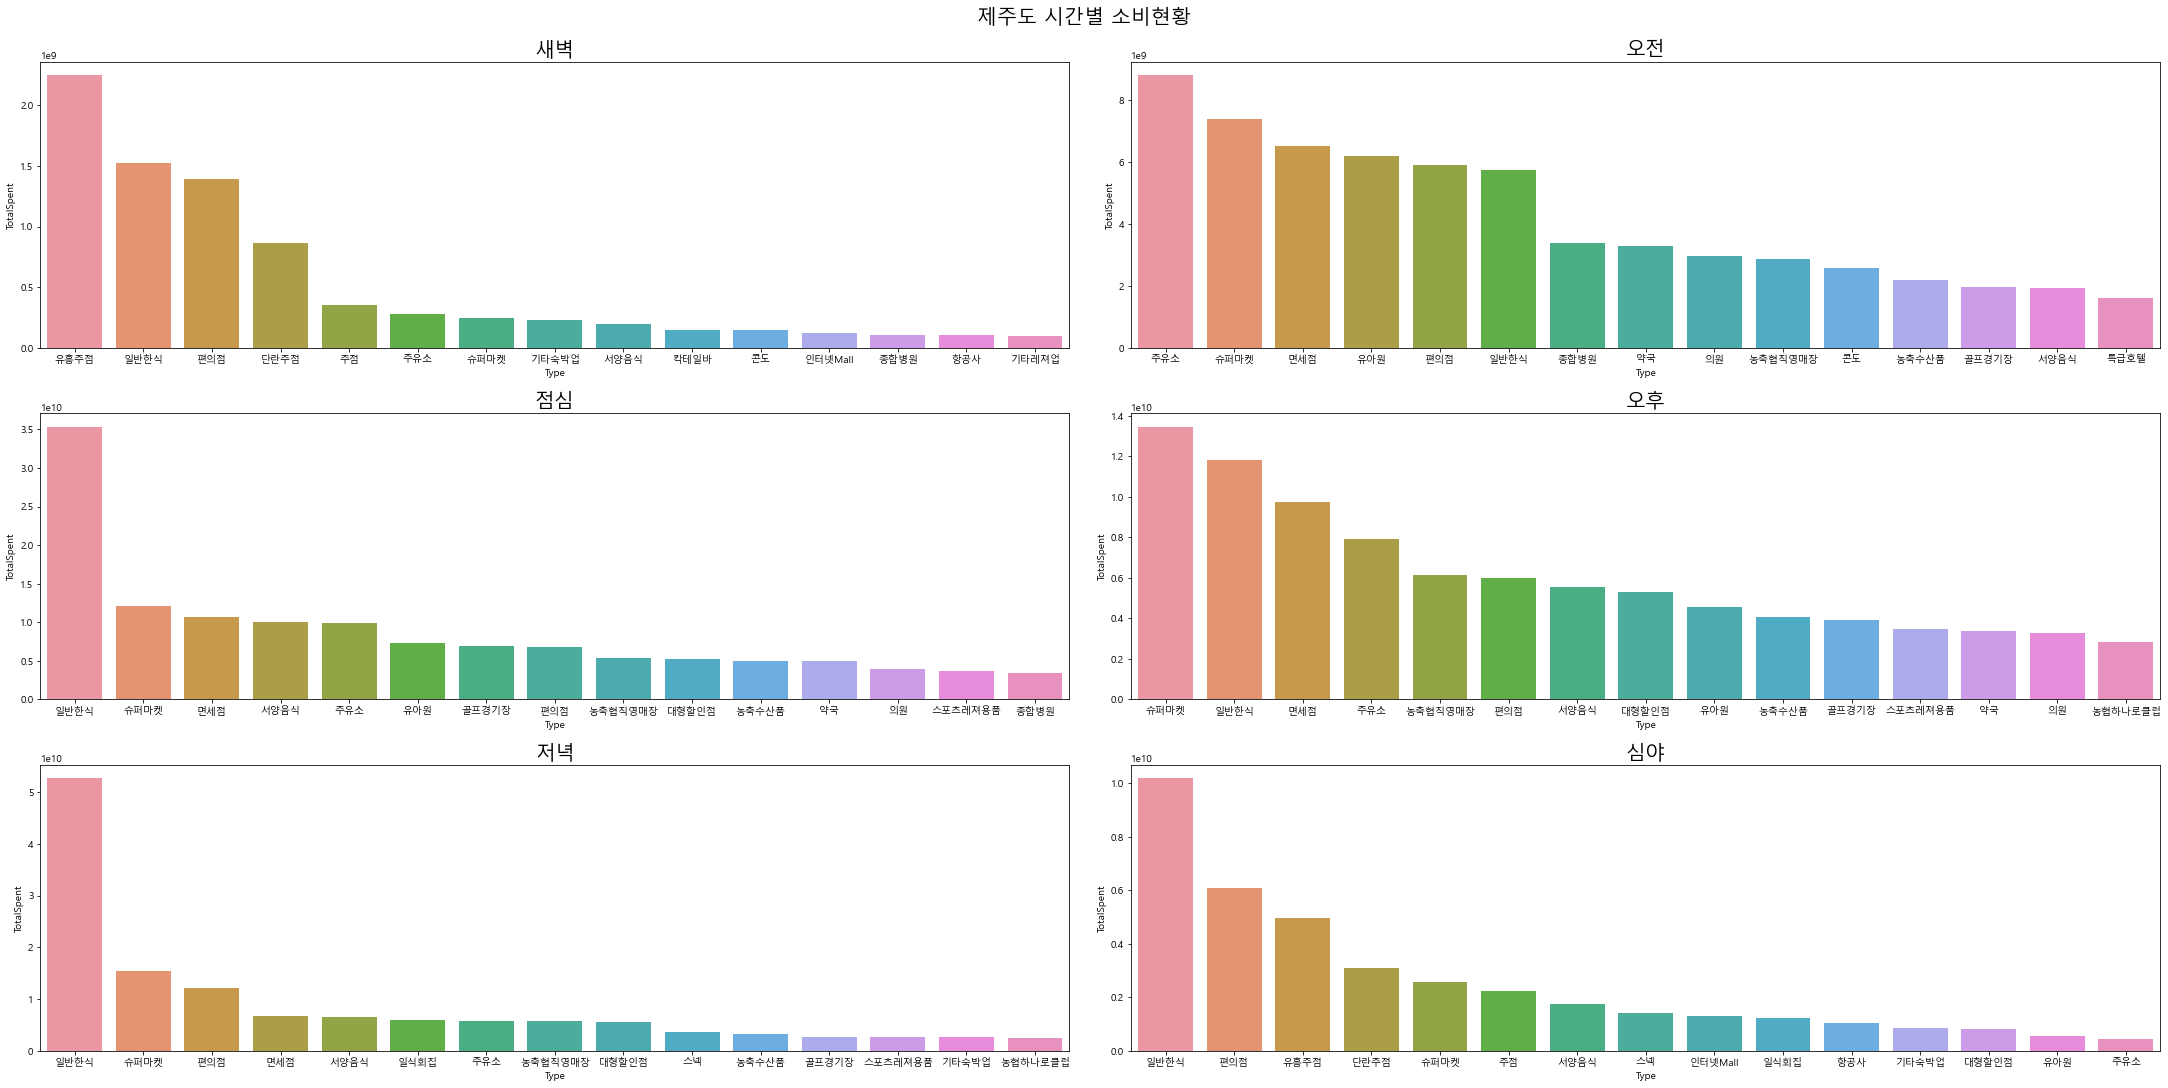

In [10]:
df_total_graph=[]
for i in list(('새벽', '오전', '점심', '오후', '저녁', '심야')):
           
    df_temp= jeju_all.groupby(['Time_cut','Type'])['TotalSpent'].sum()
    df_temp=pd.DataFrame(df_temp).sort_values('TotalSpent', ascending=False)
    df_temp.reset_index(inplace=True)
    df_total_graph.append(df_temp[df_temp['Time_cut']==i].reset_index(drop=True).head(15))

    
df_graph = pd.concat(df_total_graph, axis=0)
figure, ((ax1,ax2), (ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, constrained_layout=True)
figure.set_size_inches(30,15)

sns.barplot(data=df_graph[df_graph['Time_cut']=='새벽'], x="Type", y="TotalSpent", ax=ax1)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='오전'],  x="Type", y="TotalSpent", ax=ax2)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='점심'],  x="Type", y="TotalSpent", ax=ax3) 
sns.barplot(data=df_graph[df_graph['Time_cut']=='오후'],  x="Type",y="TotalSpent", ax=ax4)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='저녁'],  x="Type", y="TotalSpent", ax=ax5)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='심야'],  x="Type", y="TotalSpent", ax=ax6)

ax1.set_title("새벽", fontsize=20)
ax2.set_title("오전", fontsize=20)
ax3.set_title("점심", fontsize=20)
ax4.set_title("오후", fontsize=20)
ax5.set_title("저녁", fontsize=20)
ax6.set_title("심야", fontsize=20)
plt.suptitle('제주도 시간별 소비현황' ,fontsize=20)

#### 제주도에서 시간별로 많이 소비되는 업종을 살펴보면
* 새벽시간대에는 주점과 편의점에서 많이 소비된다
* 오전시간대에는 출근 시간대에 주유소에서 사용된다
* 점심시간대와 저녁시간대에서는 한식점에서 많이 소비된다
* 다양한 시간대에에서 면세점 소비가 많이 나타고 총소비금액으로 보자면 종합병원, 의원, 골프경기장도 상위권에 속해 있다.

In [11]:
# 전체 시간별, 제주도 업종별 상위 10개 (재난지원금) 사용형태을 보여줌

df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('DisSpent', i)
        df_total.append(df_temp)
    else:
        df_temp = df_time('DisSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent
0,00,일반한식,66405204,01,일반한식,41359331,02,일반한식,26119291,03,일반한식,17346828,04,편의점,13129282,05,편의점,21747792,06,편의점,42375199,07,주유소,80397642,08,슈퍼마켓,115614892,09,슈퍼마켓,189028719,10,슈퍼마켓,250782446,11,슈퍼마켓,284231227,12,일반한식,703256626,13,일반한식,515350638,14,슈퍼마켓,360608145,15,슈퍼마켓,416251344,16,슈퍼마켓,483340606,17,슈퍼마켓,550507814,18,슈퍼마켓,564824797,19,일반한식,980789240,20,일반한식,1020459187,21,일반한식,498071189,22,일반한식,225442086,23,일반한식,121573102
1,00,편의점,48770766,01,편의점,31685960,02,편의점,23012590,03,편의점,16455323,04,일반한식,8584051,05,일반한식,7510717,06,주유소,34818458,07,편의점,66995954,08,주유소,113388987,09,주유소,147347465,10,농축협직영매장,173656042,11,일반한식,262357014,12,슈퍼마켓,292163611,13,슈퍼마켓,324640860,14,일반한식,275447499,15,농축협직영매장,237849049,16,농축협직영매장,266716671,17,농축협직영매장,280701578,18,일반한식,519295082,19,슈퍼마켓,451666885,20,슈퍼마켓,364546651,21,슈퍼마켓,297906832,22,슈퍼마켓,166041419,23,편의점,77360815
2,00,주점,15592772,01,주점,9685810,02,주점,4778520,03,슈퍼마켓,3780400,04,슈퍼마켓,3474882,05,슈퍼마켓,5759705,06,슈퍼마켓,19010870,07,슈퍼마켓,58564542,08,편의점,74196640,09,농축협직영매장,123026304,10,주유소,154478728,11,농축협직영매장,181768630,12,농축협직영매장,177685366,13,농축협직영매장,185740831,14,농축협직영매장,213046699,15,주유소,165297641,16,스포츠레져용품,165556772,17,일반한식,217531436,18,농축협직영매장,278845296,19,농축협직영매장,198970015,20,편의점,155987788,21,편의점,141619714,22,편의점,111219700,23,슈퍼마켓,52859476
3,00,스넥,10798920,01,서양음식,7321420,02,슈퍼마켓,4560816,03,서양음식,2384380,04,대형할인점,1295350,05,주유소,4131258,06,일반한식,11160797,07,일반한식,23697586,08,농축협직영매장,60091735,09,약국,106665907,10,약국,134425259,11,주유소,149513862,12,주유소,140017426,13,주유소,152896528,14,주유소,166287853,15,스포츠레져용품,163588519,16,주유소,158224089,17,주유소,159331027,18,편의점,148410880,19,편의점,149169882,20,농축협직영매장,146502198,21,농축협직영매장,74408388,22,스넥,44123218,23,스넥,26219584
4,00,서양음식,9981928,01,슈퍼마켓,5746156,02,서양음식,2846600,03,주점,1883130,04,주점,953210,05,스포츠레져용품,1697930,06,LPG,3310828,07,LPG,11112464,08,일반한식,36676473,09,의원,77863180,10,의원,98856186,11,약국,128499300,12,서양음식,111138815,13,스포츠레져용품,120653376,14,스포츠레져용품,160091435,15,일반한식,160686430,16,일반한식,135452763,17,농협하나로클럽,143786348,18,주유소,143989675,19,스포츠레져용품,112396225,20,일식회집,93518476,21,스넥,57952158,22,서양음식,30407468,23,주점,23772515
5,00,슈퍼마켓,9493424,01,스넥,4157191,02,기타숙박업,2108000,03,대형할인점,1502230,04,종합병원,713090,05,사우나,1432080,06,사우나,3229400,07,농축협직영매장,8972840,08,농협하나로클럽,26496240,09,편의점,74508881,10,농협하나로클럽,93406102,11,의원,105838534,12,편의점,106398297,13,서양음식,109552413,14,농협하나로클럽,121593727,15,농협하나로클럽,126885900,16,농협하나로클럽,133727820,17,스포츠레져용품,137550254,18,농협하나로클럽,125409437,19,서양음식,99658582,20,서양음식,90591948,21,서양음식,56639704,22,주점,25523562,23,서양음식,16142356
6,00,일식회집,5099200,01,일식회집,3841940,02,종합병원,1998450,03,기타숙박업,996853,04,기타숙박업,625000,05,종합병원,1361540,06,스포츠레져용품,3132477,07,농축수산품,7983520,08,약국,23738910,09,농협하나로클럽,62649634,10,일반한식,90926872,11,농협하나로클럽,101622332,12,스포츠레져용품,99851707,13,농협하나로클럽,105409843,14,약국,111099767,15,편의점,109219257,16,편의점,115811015,17,편의점,126770243,18,스포츠레져용품,125389228,19,주유소,90775614,20,스포츠레져용품,90562690,21,일식회집,56316732,22,일식회집,20662003,23,일식회집,11330115
7,00,대형할인점,3022150,01,기타숙박업,1958060,02,대형할인점,1629250,03,종합병원,839930,04,스넥,550000,05,대형할인점,1313780,06,화물운송,2683298,07,제과점,6788182,08,종합병원,23394005,09,일반한식,60986688,10,종합병원,83677217,11,편의점,83083955,12,농협하나로클럽,98602056,13,편의점,104832692,14,편의점,103816586,15,약국,106616834,16,약국,98153518,17,약국,81862689,18,스넥,73541474,19,농협하나로클럽,86548712,20,농협하나로클럽,75311572,21,농협하나로클럽,49999093,22,제과점,10905569,23,보습학원,4611780
8,00,볼링장,2364897,01,대형할인점,1482831,02,스넥,1291710,03,기타레져업,818930,04,서양음식,463990,05,기타숙박업,1078720,06,종합병원,1881660,07,비료농약사료종자,5755654,08,농축수산품,19170532,09,종합병원,58874374,10,편의점,76152719,11,스포츠레져용

Text(0.5, 0.98, '제주도 시간별(재난지원금) 소비현황')

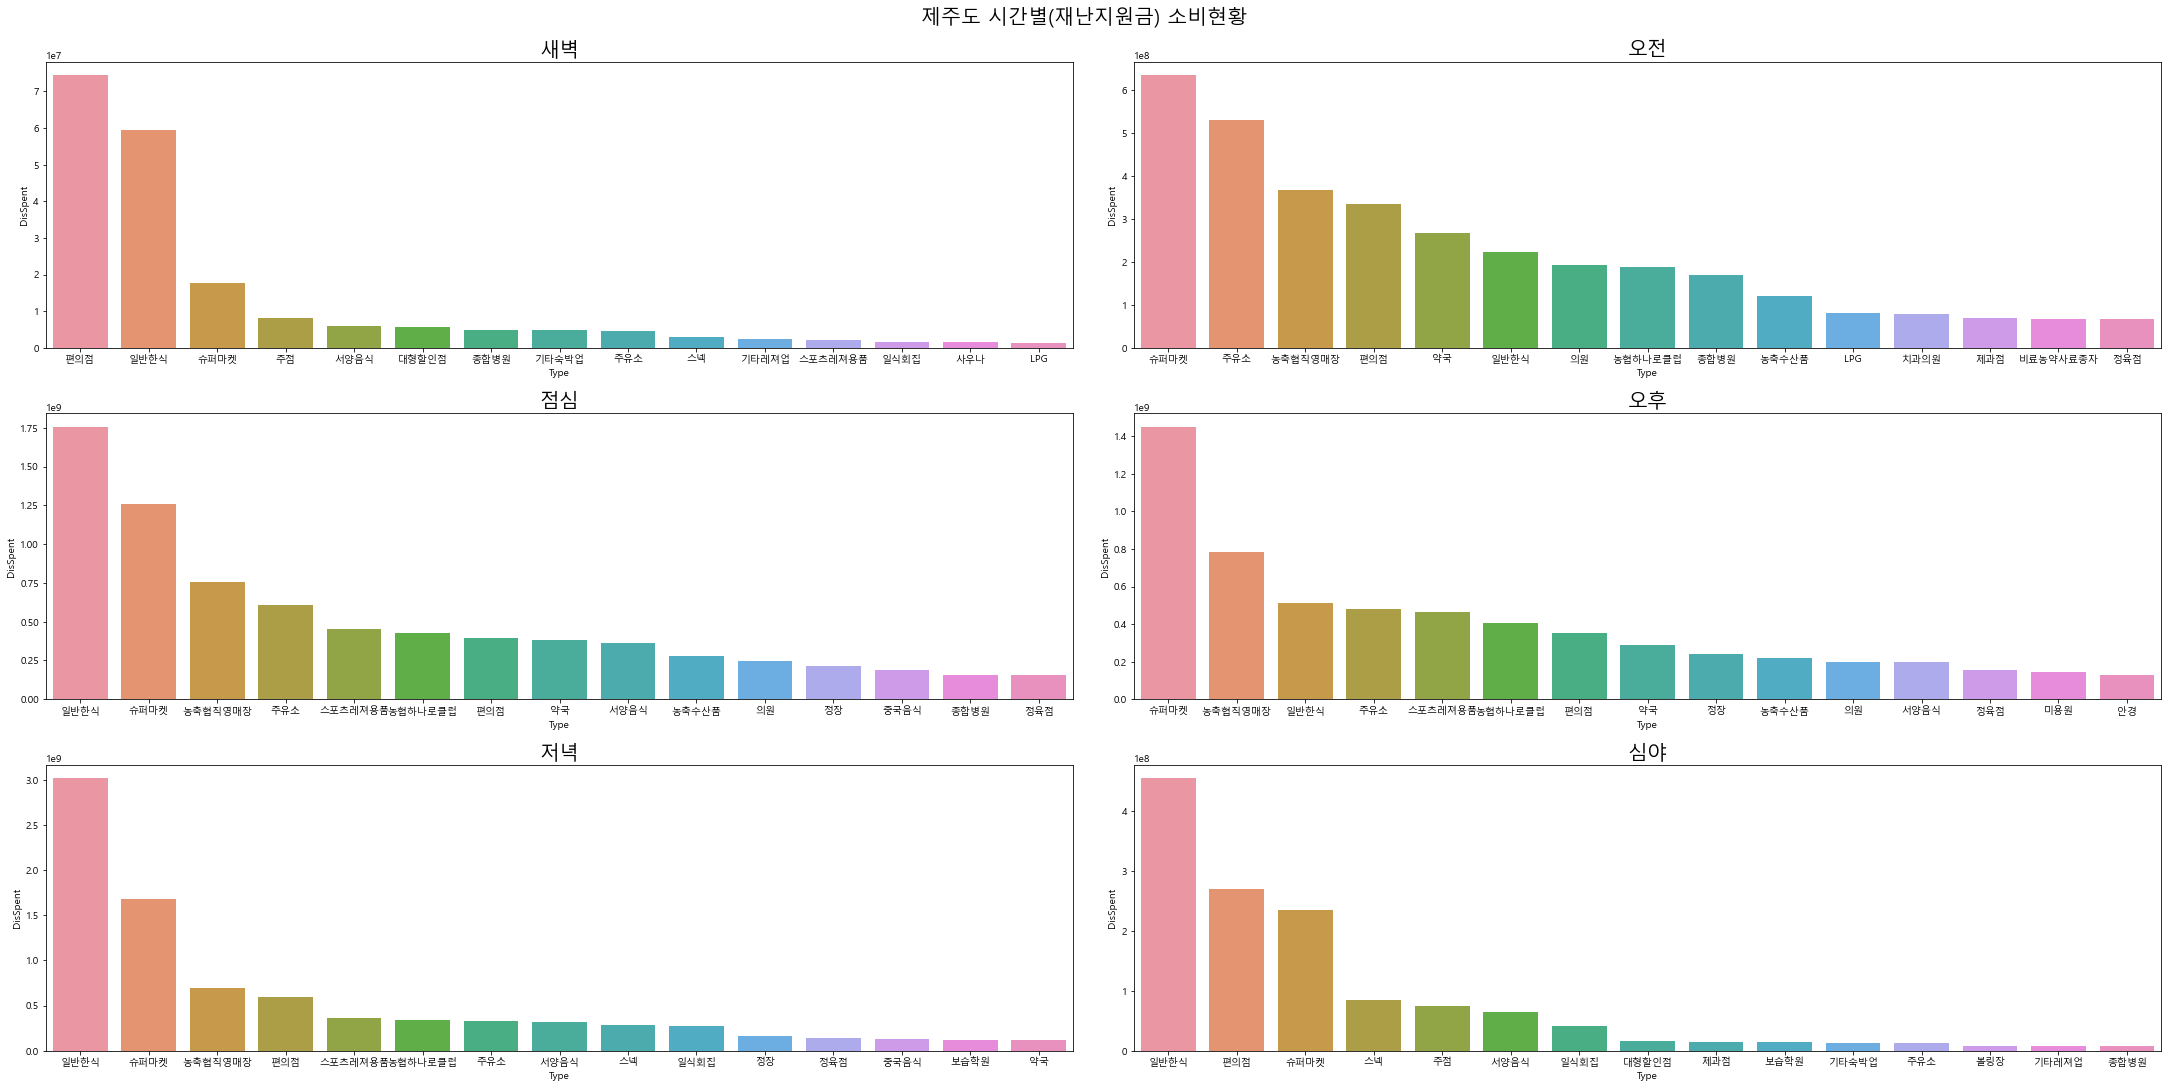

In [12]:
df_total_graph=[]
for i in list(('새벽', '오전', '점심', '오후', '저녁', '심야')):
           
    df_temp= jeju_all.groupby(['Time_cut','Type'])['DisSpent'].sum()
    df_temp=pd.DataFrame(df_temp).sort_values('DisSpent', ascending=False)
    df_temp.reset_index(inplace=True)
    df_total_graph.append(df_temp[df_temp['Time_cut']==i].reset_index(drop=True).head(15))

    
df_graph = pd.concat(df_total_graph, axis=0)
figure, ((ax1,ax2), (ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, constrained_layout=True)
figure.set_size_inches(30,15)

sns.barplot(data=df_graph[df_graph['Time_cut']=='새벽'], x="Type", y="DisSpent", ax=ax1)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='오전'],  x="Type", y="DisSpent", ax=ax2)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='점심'],  x="Type", y="DisSpent", ax=ax3) 
sns.barplot(data=df_graph[df_graph['Time_cut']=='오후'],  x="Type",y="DisSpent", ax=ax4)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='저녁'],  x="Type", y="DisSpent", ax=ax5)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='심야'],  x="Type", y="DisSpent", ax=ax6)

ax1.set_title("새벽", fontsize=20)
ax2.set_title("오전", fontsize=20)
ax3.set_title("점심", fontsize=20)
ax4.set_title("오후", fontsize=20)
ax5.set_title("저녁", fontsize=20)
ax6.set_title("심야", fontsize=20)
plt.suptitle('제주도 시간별(재난지원금) 소비현황' ,fontsize=20)

#### 제주도에서 시간별로 재난지원금 사용행태를 업종으로 살펴보면
* 새벽시간대에는 주점과 편의점에서, 출근 시간대에 주유소에서 사용된다
* 점심시간대와 저녁시간대에서는 한식점에서 많이 소비되며 특정시간을 제외하면 슈퍼마켓에서 주로 재난지원금이 사용된다.

In [13]:
def df_time(a,b,c):
    """a는 제주시 or 서귀포시 하나를 입력
    b는 DisSpent or TotalSpent
    c는 시간을 문자열로"""
    df_temp= jeju_all[jeju_all['SIGUNGU']==a].groupby(['Time','Type'])[b].sum()
    df_temp=pd.DataFrame(df_temp).sort_values(b, ascending=False)
    df_temp.reset_index(inplace=True)
    return df_temp[df_temp['Time']==c].reset_index().head(10)

In [14]:
# 전체 시간별, 제주시 업종별 상위 10개 총사용금액을 보여줌(총사용금액)
df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('제주시', 'TotalSpent', i )
        df_total.append(df_temp)
    else:
        df_temp = df_time('제주시', 'TotalSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent
0,00,일반한식,1407801782,01,일반한식,901702835,02,유흥주점,688764033,03,유흥주점,479139740,04,유흥주점,280344200,05,편의점,268270250,06,편의점,543819058,07,면세점,1046321630,08,면세점,1355853960,09,유아원,1870278720,10,유아원,2075022350,11,일반한식,3954555083,12,일반한식,9221923097,13,일반한식,7032846076,14,일반한식,4618427997,15,일반한식,3012713924,16,슈퍼마켓,3357530548,17,슈퍼마켓,3769325007,18,일반한식,6235889437,19,일반한식,10959197456,20,일반한식,12547319323,21,일반한식,7508008347,22,일반한식,3675093817,23,일반한식,2218848821
1,00,유흥주점,929235134,01,유흥주점,859121591,02,일반한식,588921004,03,일반한식,374921560,04,일반한식,198593723,05,유흥주점,168783700,06,주유소,485398650,07,주유소,989042044,08,주유소,1339859731,09,면세점,1689285439,10,슈퍼마켓,1998628582,11,면세점,2112373240,12,면세점,2579277960,13,면세점,2446405193,14,면세점,2538693895,15,면세점,2981672465,16,면세점,3320759775,17,일반한식,3111728608,18,슈퍼마켓,3866072300,19,슈퍼마켓,3200943449,20,슈퍼마켓,2625495880,21,슈퍼마켓,2183226206,22,편의점,1774343518,23,편의점,1255976865
2,00,편의점,801763750,01,단란주점,601556518,02,단란주점,415872700,03,편의점,244301900,04,편의점,192252569,05,일반한식,145814640,06,면세점,374407590,07,편의점,858303420,08,슈퍼마켓,981474048,09,슈퍼마켓,1631347143,10,면세점,1943990435,11,슈퍼마켓,2021154729,12,슈퍼마켓,2056531844,13,슈퍼마켓,2229145753,14,슈퍼마켓,2493873870,15,슈퍼마켓,2825773399,16,일반한식,2326374246,17,면세점,2698222642,18,면세점,2208141510,19,면세점,2334252197,20,편의점,2220891771,21,편의점,2183091258,22,슈퍼마켓,1377890608,23,유흥주점,870942200
3,00,단란주점,655288940,01,편의점,518121921,02,편의점,351621358,03,단란주점,175273567,04,주유소,67770498,05,주유소,124323044,06,일반한식,234842688,07,슈퍼마켓,535214330,08,편의점,967745290,09,주유소,1557477186,10,일반한식,1905421039,11,주유소,1680136102,12,서양음식,1904271135,13,서양음식,1906939763,14,주유소,1762567148,15,주유소,1786282683,16,주유소,1845681855,17,주유소,1834965231,18,편의점,1847333572,19,편의점,1976539959,20,면세점,1922705276,21,일식회집,946137288,22,유흥주점,642935834,23,단란주점,638476500
4,00,주점,399844313,01,주점,266667194,02,주점,157748150,03,주점,68931917,04,단란주점,61494600,05,슈퍼마켓,73631960,06,슈퍼마켓,175002290,07,일반한식,392307441,08,일반한식,616994529,09,약국,1149124957,10,주유소,1656503444,11,유아원,1610329700,12,주유소,1625505222,13,주유소,1739621121,14,서양음식,1710789973,15,서양음식,1419086917,16,편의점,1387477318,17,편의점,1520590089,18,주유소,1701920991,19,서양음식,1251589976,20,일식회집,1298255110,21,서양음식,815924216,22,주점,541003758,23,주점,516129188
5,00,서양음식,252106710,01,서양음식,165690430,02,서양음식,92690990,03,슈퍼마켓,51316040,04,슈퍼마켓,44333930,05,단란주점,26316100,06,골프경기장,162541240,07,골프경기장,266200742,08,유아원,583405690,09,일반한식,1121797105,10,종합병원,1624209070,11,종합병원,1410255711,12,골프경기장,1428912388,13,유아원,1432348840,14,유아원,1314649820,15,편의점,1315667980,16,유아원,1233818270,17,골프경기장,1269472464,18,농축협직영매장,1127878060,19,주유소,1168850699,20,서양음식,1219670434,21,대형할인점,786027880,22,서양음식,526932408,23,슈퍼마켓,509511671
6,00,인터넷Mall,240513708,01,인터넷Mall,134106140,02,기타숙박업,66801708,03,서양음식,51104390,04,주점,34965550,05,기타숙박업,25634397,06,화물운송,115288840,07,기타건축자재,154535232,08,렌트카,424367835,09,종합병원,981002920,10,약국,1403301953,11,약국,1386428186,12,유아원,1359970940,13,편의점,1240630600,14,편의점,1242114682,15,유아원,1230003090,16,서양음식,1171798705,17,농축협직영매장,1206103663,18,서양음식,1087807096,19,일식회집,980927860,20,대형할인점,894857880,21,스넥,572945909,22,단란주점,516894890,23,인터넷Mall,409874427
7,00,항공사,207568300,01,항공사,101958200,02,슈퍼마켓,66418500,03,기타숙박업,51077137,04,기타숙박업,34391285,05,인터넷Mall,24885807,06,유흥주점,87957050,07,유아원,134468830,08,종합병원,412144620,09,의원,971633270,10,의원,1362345894,11,의원,1344418590,12,편의점,1344125545,13,골프경기장,1216685771,14,약국,1147712231,15,대형할인점,1084144050,16,대형할인점,1125060670,17,대형할인점,1118279280,18,골프경기장,1085152038,19,농축협직영매장,888798030,20,주유소,755113800,21,주유소,510361922,22,인터넷Mall,504076981,23,서양음식,35

In [15]:
# 전체 시간별, 서귀포시 업종별 상위 10개 총사용금액을 보여줌(총사용금액)
df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('서귀포시', 'TotalSpent', i )
        df_total.append(df_temp)
    else:
        df_temp = df_time('서귀포시', 'TotalSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent
0,00,유흥주점,448084700,01,유흥주점,390357700,02,유흥주점,318545010,03,유흥주점,174018308,04,유흥주점,98658870,05,편의점,93361910,06,편의점,203831140,07,주유소,444586068,08,주유소,627665541,09,주유소,729050596,10,콘도,827864238,11,일반한식,1619380378,12,일반한식,3763534901,13,일반한식,3065013500,14,일반한식,2050637248,15,일반한식,1259054102,16,슈퍼마켓,1211732650,17,일반한식,1243767190,18,일반한식,2783368058,19,일반한식,4961714275,20,일반한식,5029541372,21,일반한식,2646157719,22,일반한식,1041420577,23,편의점,501855890
1,00,일반한식,270162664,01,일반한식,165933896,02,편의점,108758460,03,편의점,73049310,04,편의점,60448620,05,콘도,41427954,06,주유소,199031684,07,편의점,325691510,08,슈퍼마켓,407069987,09,슈퍼마켓,634314775,10,주유소,776933842,11,특급호텔,927546983,12,서양음식,962273638,13,서양음식,1016698110,14,서양음식,957785189,15,슈퍼마켓,1064390294,16,농축협직영매장,986288964,17,슈퍼마켓,1235154358,18,슈퍼마켓,1206998550,19,슈퍼마켓,970438112,20,편의점,1064236310,21,편의점,1061816491,22,편의점,797399500,23,일반한식,500172944
2,00,편의점,268004811,01,편의점,161737330,02,단란주점,98219010,03,일반한식,60760400,04,콘도,38188611,05,유흥주점,36252710,06,골프경기장,166322620,07,슈퍼마켓,230862660,08,편의점,392393370,09,유아원,610415050,10,특급호텔,739324647,11,콘도,820067078,12,골프경기장,862993200,13,슈퍼마켓,811497724,14,슈퍼마켓,941236686,15,서양음식,823170686,16,일반한식,864510596,17,농축협직영매장,1091384790,18,농축협직영매장,1073449780,19,편의점,913738737,20,일식회집,795302979,21,슈퍼마켓,575208187,22,유흥주점,351708700,23,유흥주점,470663378
3,00,단란주점,174926000,01,단란주점,147725113,02,일반한식,89971516,03,단란주점,46428000,04,일반한식,35250100,05,일반한식,24851021,06,슈퍼마켓,74944060,07,골프경기장,220525651,08,콘도,250740236,09,콘도,504106218,10,슈퍼마켓,725408487,11,주유소,793563588,12,슈퍼마켓,781607175,13,주유소,767414373,14,주유소,828723449,15,농축협직영매장,814371790,16,주유소,821630080,17,골프경기장,842897359,18,편의점,804793480,19,농축협직영매장,774009420,20,슈퍼마켓,755741801,21,일식회집,553316400,22,슈퍼마켓,347180098,23,단란주점,186097115
4,00,주점,109917060,01,주점,75097340,02,주점,45149136,03,콘도,28122956,04,단란주점,22985000,05,주유소,23715370,06,콘도,58520649,07,일반한식,123541040,08,농축협직영매장,246258410,09,농축협직영매장,465774964,10,일반한식,654374524,11,슈퍼마켓,739132333,12,주유소,730790444,13,골프경기장,765996718,14,농축협직영매장,723718486,15,주유소,810503749,16,대형할인점,681648000,17,주유소,824487706,18,주유소,710851213,19,서양음식,626663925,20,서양음식,583218349,21,대형할인점,444329250,22,대형할인점,270742310,23,주점,149737903
5,00,서양음식,69256950,01,서양음식,32899740,02,콘도,20585297,03,주점,17031000,04,기타숙박업,9211520,05,단란주점,16315000,06,일반한식,47694900,07,콘도,114769080,08,일반한식,233818870,09,일반한식,429078280,10,농축협직영매장,638125868,11,골프경기장,665970532,12,편의점,520559170,13,농축협직영매장,610617919,14,특급호텔,598786738,15,대형할인점,643267390,16,서양음식,633216711,17,대형할인점,669173450,18,골프경기장,693089156,19,일식회집,617885777,20,농축협직영매장,547649320,21,서양음식,357111480,22,일식회집,227363700,23,스넥,132711190
6,00,스넥,56404905,01,기타숙박업,25139222,02,기타숙박업,20349245,03,기타숙박업,10045179,04,주점,8246200,05,스포츠레져용품,12894800,06,유흥주점,18550500,07,유아원,61287990,08,유아원,215046920,09,편의점,381238690,10,유아원,610780730,11,농축협직영매장,603395186,12,농축협직영매장,511262292,13,편의점,496573454,14,대형할인점,551790780,15,콘도,618344080,16,편의점,572717354,17,편의점,652303662,18,대형할인점,619380710,19,대형할인점,539525550,20,대형할인점,490012650,21,스넥,249279280,22,서양음식,222343185,23,서양음식,129287200
7,00,기타숙박업,40934196,01,스넥,19981300,02,서양음식,16121840,03,특급호텔,8203676,04,스포츠레져용품,4120000,05,골프경기장,11044580,06,스포츠레져용품,18242200,07,서양음식,54278838,08,특급호텔,123223431,09,특급호텔,303269509,10,편의점,390304320,11,서양음식,585960365,12,농축수산품,483559630,13,대형할인점,474230920,14,편의점,515963618,15,편의점,544046330,16,골프경기장,511600711,17,서양음식,525398701,18,서양음식,543480231,19,주유소,457055464,20,농축수산품,320648720,21,유흥주점,245467500,22,스넥,193958480,23,일식회집,89813000
8,00,일식회집,36040200,01,일식회집,15627400,02,스넥,7939300,03,서양음식,72315

Text(0.5, 0.98, '제주시 시간별 소비현황')

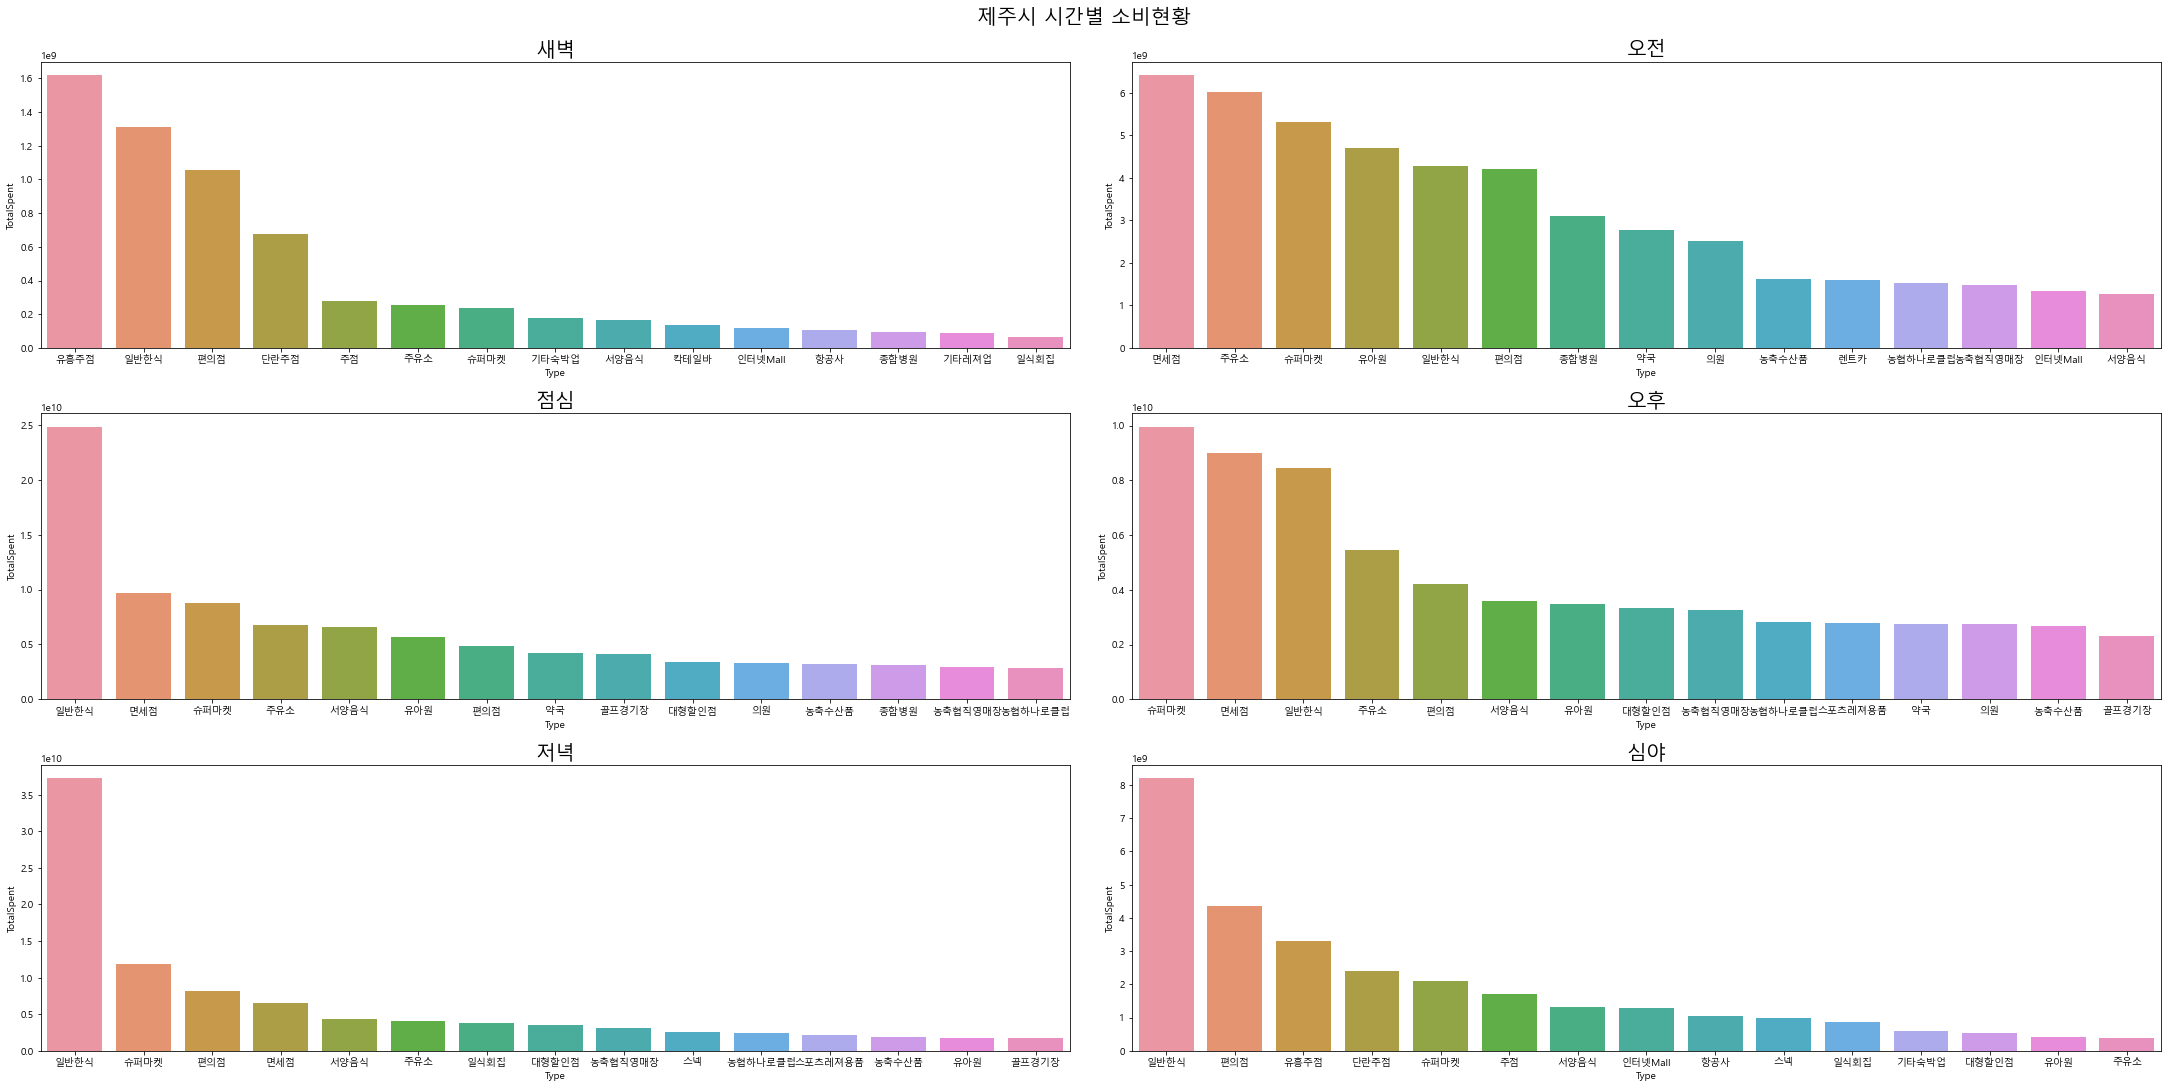

In [16]:
df_total_graph=[]
for i in list(('새벽', '오전', '점심', '오후', '저녁', '심야')):
           
    df_temp= jeju_all[jeju_all['SIGUNGU']=='제주시'].groupby(['Time_cut','Type'])['TotalSpent'].sum()
    df_temp=pd.DataFrame(df_temp).sort_values('TotalSpent', ascending=False)
    df_temp.reset_index(inplace=True)
    df_total_graph.append(df_temp[df_temp['Time_cut']==i].reset_index(drop=True).head(15))

    
df_graph = pd.concat(df_total_graph, axis=0)
figure, ((ax1,ax2), (ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, constrained_layout=True)
figure.set_size_inches(30,15)

sns.barplot(data=df_graph[df_graph['Time_cut']=='새벽'], x="Type", y="TotalSpent", ax=ax1)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='오전'],  x="Type", y="TotalSpent", ax=ax2)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='점심'],  x="Type", y="TotalSpent", ax=ax3) 
sns.barplot(data=df_graph[df_graph['Time_cut']=='오후'],  x="Type",y="TotalSpent", ax=ax4)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='저녁'],  x="Type", y="TotalSpent", ax=ax5)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='심야'],  x="Type", y="TotalSpent", ax=ax6)

ax1.set_title("새벽", fontsize=20)
ax2.set_title("오전", fontsize=20)
ax3.set_title("점심", fontsize=20)
ax4.set_title("오후", fontsize=20)
ax5.set_title("저녁", fontsize=20)
ax6.set_title("심야", fontsize=20)
plt.suptitle('제주시 시간별 소비현황' ,fontsize=20)

Text(0.5, 0.98, '서귀포시 시간별 소비현황')

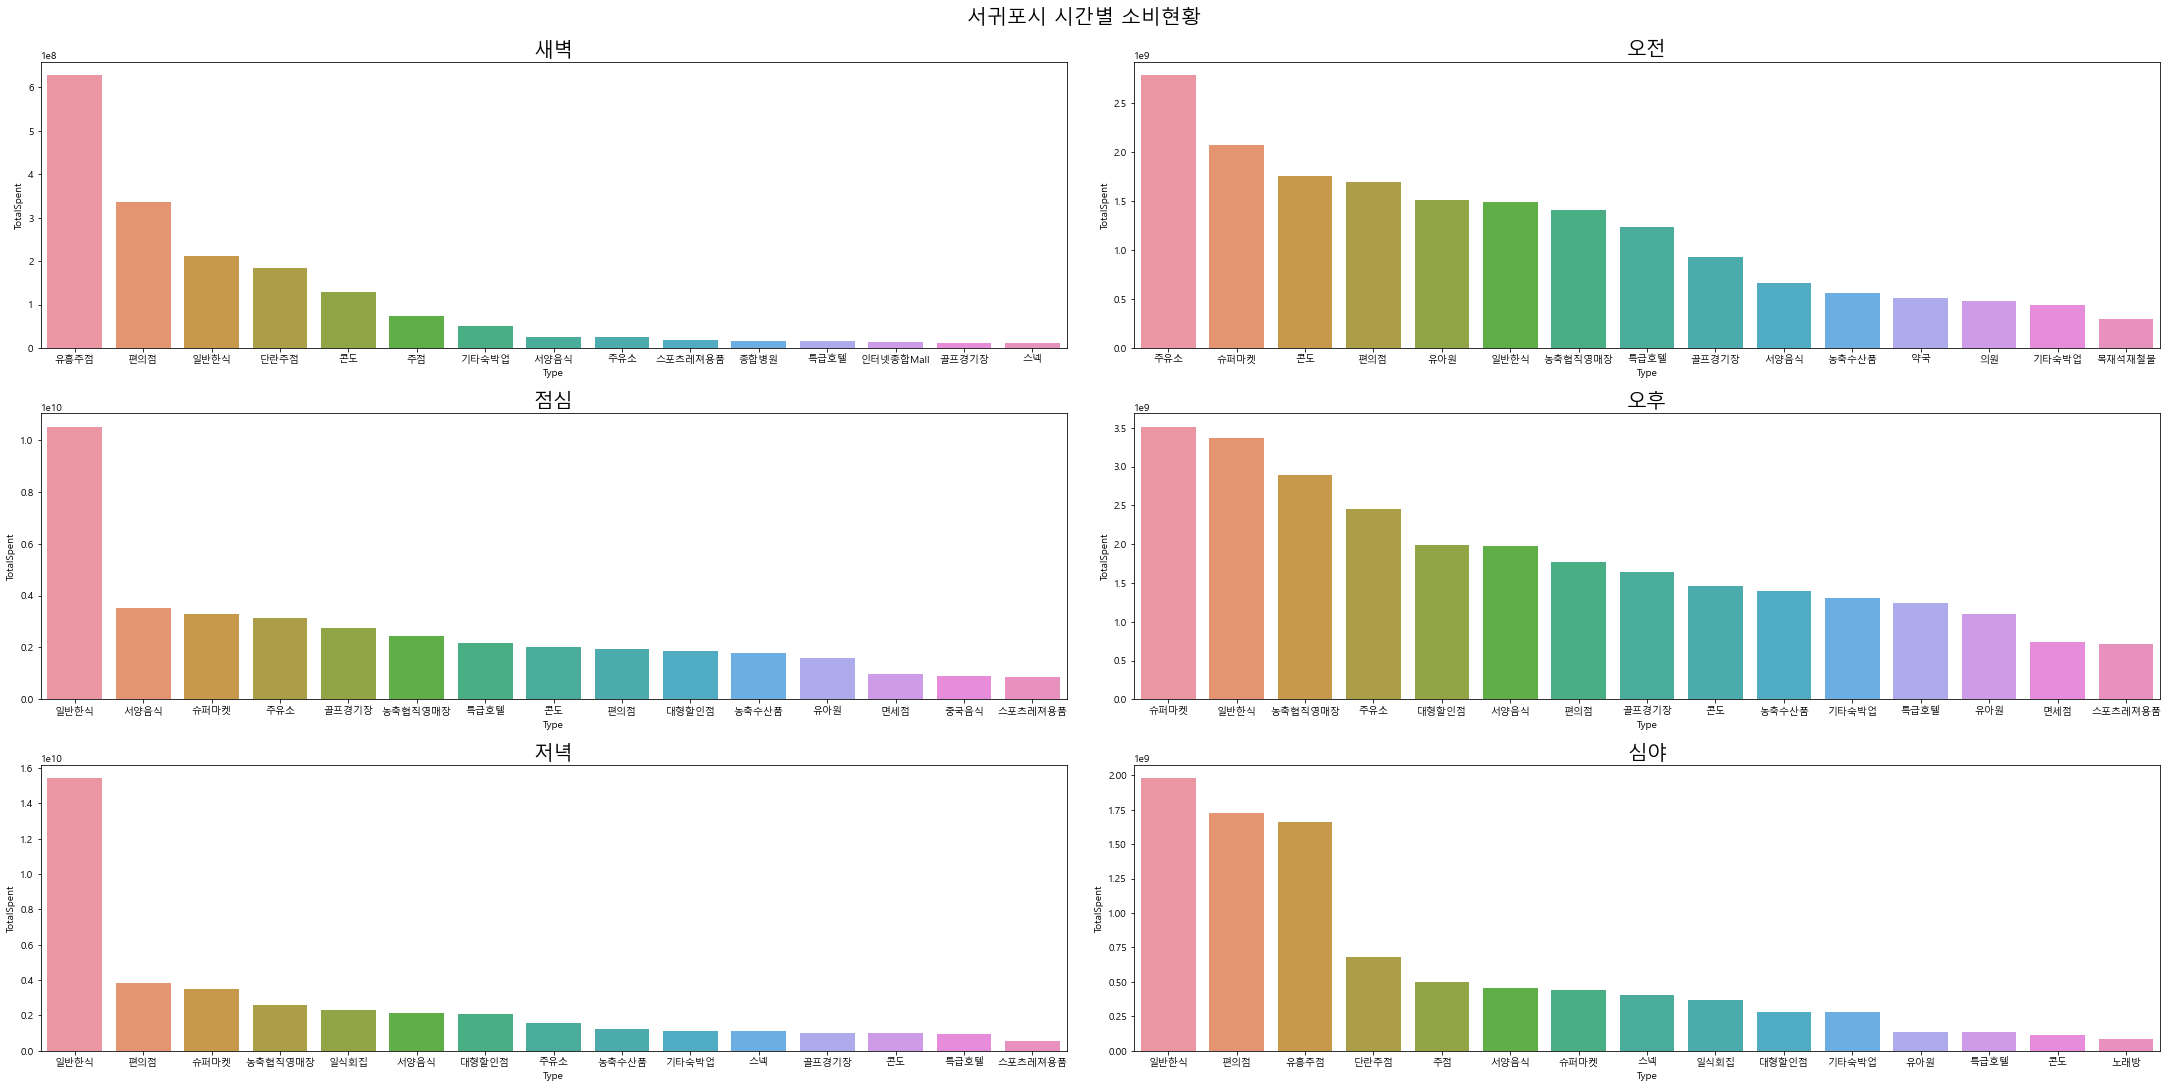

In [17]:
df_total_graph=[]
for i in list(('새벽', '오전', '점심', '오후', '저녁', '심야')):
           
    df_temp= jeju_all[jeju_all['SIGUNGU']=='서귀포시'].groupby(['Time_cut','Type'])['TotalSpent'].sum()
    df_temp=pd.DataFrame(df_temp).sort_values('TotalSpent', ascending=False)
    df_temp.reset_index(inplace=True)
    df_total_graph.append(df_temp[df_temp['Time_cut']==i].reset_index(drop=True).head(15))

    
df_graph = pd.concat(df_total_graph, axis=0)
figure, ((ax1,ax2), (ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, constrained_layout=True)
figure.set_size_inches(30,15)

sns.barplot(data=df_graph[df_graph['Time_cut']=='새벽'], x="Type", y="TotalSpent", ax=ax1)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='오전'],  x="Type", y="TotalSpent", ax=ax2)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='점심'],  x="Type", y="TotalSpent", ax=ax3) 
sns.barplot(data=df_graph[df_graph['Time_cut']=='오후'],  x="Type",y="TotalSpent", ax=ax4)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='저녁'],  x="Type", y="TotalSpent", ax=ax5)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='심야'],  x="Type", y="TotalSpent", ax=ax6)

ax1.set_title("새벽", fontsize=20)
ax2.set_title("오전", fontsize=20)
ax3.set_title("점심", fontsize=20)
ax4.set_title("오후", fontsize=20)
ax5.set_title("저녁", fontsize=20)
ax6.set_title("심야", fontsize=20)
plt.suptitle('서귀포시 시간별 소비현황' ,fontsize=20)

#### 제주시와 서귀포시의 시간별 총 사용금액을 업종별로 비교해보면
* 크게차이는 없지만(일반한식, 슈퍼마켓 등 먹기리가 상위권을 차지)
* 제주시는 면세점이 총 소비의 상위권을 차지하고 있으며 종합병원, 의원도 보인다.
* 서귀포시는 콘도, 골프경기장, 특급호텔이 눈에 띄게 나타남

In [19]:
# 지원금 총 사용 금액의 비율

jeju_all['dis/tot'] = round(jeju_all['DisSpent'] / jeju_all['TotalSpent'],1)

In [20]:
# 월별 업종별로 그룹핑하여 평균 구하기

jeju_type = jeju_all.groupby(['YM', 'Type'], as_index=False).mean()

In [21]:
# 총 이용건수와 총 재난지원금 이용건수 컬럼의 정규화 과정
## 월별로 각 컬럼의 최대값으로 나누어 줌

col = ['NumofSpent', 'NumofDisSpent']
num_jeju_type_5 = (jeju_type[jeju_type['YM'] == 202005][col]) / (jeju_type[jeju_type['YM'] == 202005][col].max())
num_jeju_type_6 = (jeju_type[jeju_type['YM'] == 202006][col]) / (jeju_type[jeju_type['YM'] == 202006][col].max())
num_jeju_type_7 = (jeju_type[jeju_type['YM'] == 202007][col]) / (jeju_type[jeju_type['YM'] == 202007][col].max())
num_jeju_type_8 = (jeju_type[jeju_type['YM'] == 202008][col]) / (jeju_type[jeju_type['YM'] == 202008][col].max())

norm_jeju_type_5 = jeju_type[jeju_type['YM'] == 202005].copy()
norm_jeju_type_6 = jeju_type[jeju_type['YM'] == 202006].copy()
norm_jeju_type_7 = jeju_type[jeju_type['YM'] == 202007].copy()
norm_jeju_type_8 = jeju_type[jeju_type['YM'] == 202008].copy()

norm_jeju_type_5[col] = num_jeju_type_5[col]
norm_jeju_type_6[col] = num_jeju_type_6[col]
norm_jeju_type_7[col] = num_jeju_type_7[col]
norm_jeju_type_8[col] = num_jeju_type_8[col]

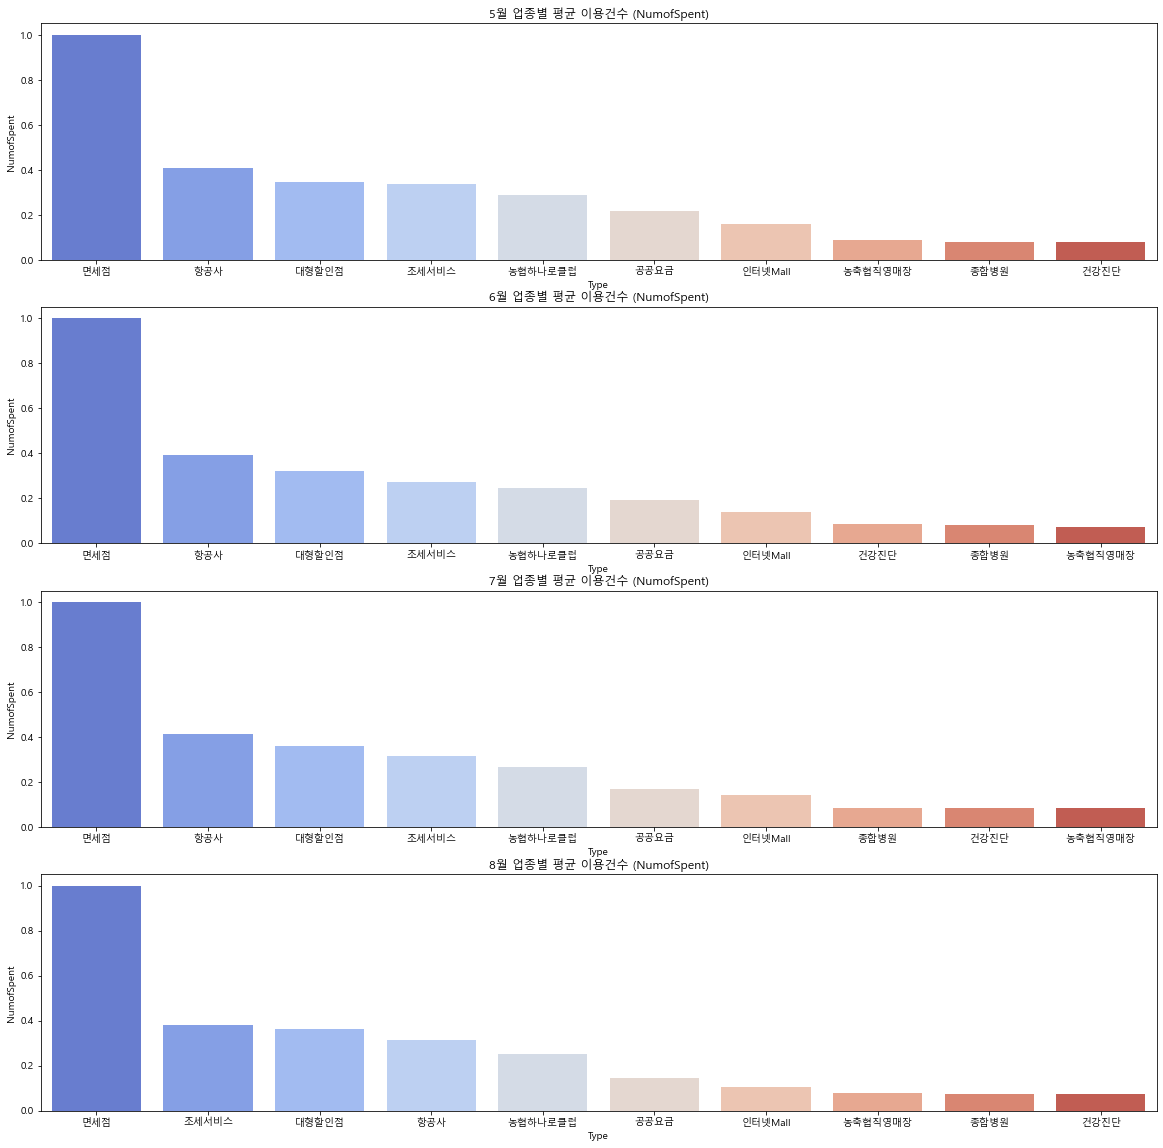

In [22]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(411)
ax1 = sns.barplot(x='Type', y='NumofSpent', data=norm_jeju_type_5.nlargest(10, 'NumofSpent'), palette='coolwarm')
ax1.set_title('5월 업종별 평균 이용건수 (NumofSpent)')

ax2 = fig.add_subplot(412)
ax2 = sns.barplot(x='Type', y='NumofSpent', data=norm_jeju_type_6.nlargest(10, 'NumofSpent'), palette='coolwarm')
ax2.set_title('6월 업종별 평균 이용건수 (NumofSpent)')

ax3 = fig.add_subplot(413)
ax3 = sns.barplot(x='Type', y='NumofSpent', data=norm_jeju_type_7.nlargest(10, 'NumofSpent'), palette='coolwarm')
ax3.set_title('7월 업종별 평균 이용건수 (NumofSpent)')

ax4 = fig.add_subplot(414)
ax4 = sns.barplot(x='Type', y='NumofSpent', data=norm_jeju_type_8.nlargest(10, 'NumofSpent'), palette='coolwarm')
ax4.set_title('8월 업종별 평균 이용건수 (NumofSpent)')
plt.show()

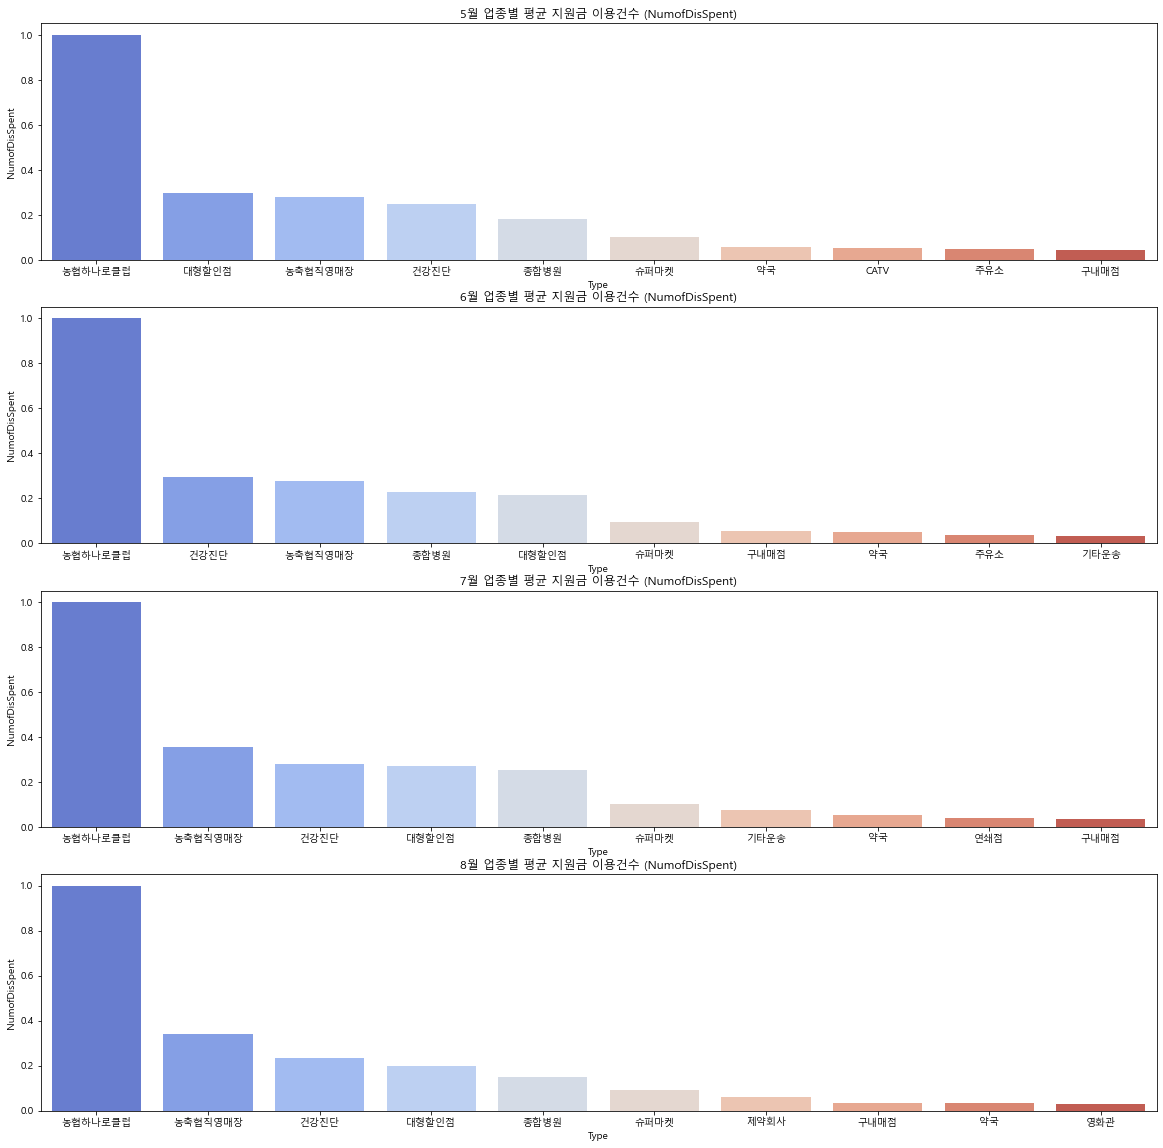

In [23]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(411)
ax1 = sns.barplot(x='Type', y='NumofDisSpent', data=norm_jeju_type_5.nlargest(10, 'NumofDisSpent'), palette='coolwarm')
ax1.set_title('5월 업종별 평균 지원금 이용건수 (NumofDisSpent)')

ax2 = fig.add_subplot(412)
ax2 = sns.barplot(x='Type', y='NumofDisSpent', data=norm_jeju_type_6.nlargest(10, 'NumofDisSpent'), palette='coolwarm')
ax2.set_title('6월 업종별 평균 지원금 이용건수 (NumofDisSpent)')

ax3 = fig.add_subplot(413)
ax3 = sns.barplot(x='Type', y='NumofDisSpent', data=norm_jeju_type_7.nlargest(10, 'NumofDisSpent'), palette='coolwarm')
ax3.set_title('7월 업종별 평균 지원금 이용건수 (NumofDisSpent)')

ax4 = fig.add_subplot(414)
ax4 = sns.barplot(x='Type', y='NumofDisSpent', data=norm_jeju_type_8.nlargest(10, 'NumofDisSpent'), palette='coolwarm')
ax4.set_title('8월 업종별 평균 지원금 이용건수 (NumofDisSpent)')
plt.show()

#### 월별 평균 이용건수 TOP10 업종
월별 평균 이용건수가 높은 상위 10개 업종들은 크게 달라지지 않음
- 면세점, 항공사와 같이 관광업종이 상위권을 차지하지만 휴가철이 끝나가는 8월에는 항공사의 순위가 떨어지는 것을 볼 수 있음

#### 월별 평균 재난지원금 이용건수 TOP10 업종
재난지원금은 주로 생활 영역에서 사용되는 것을 볼 수 있음
- 마트, 의료 영역의 업종에서 평균 이용건수가 많음

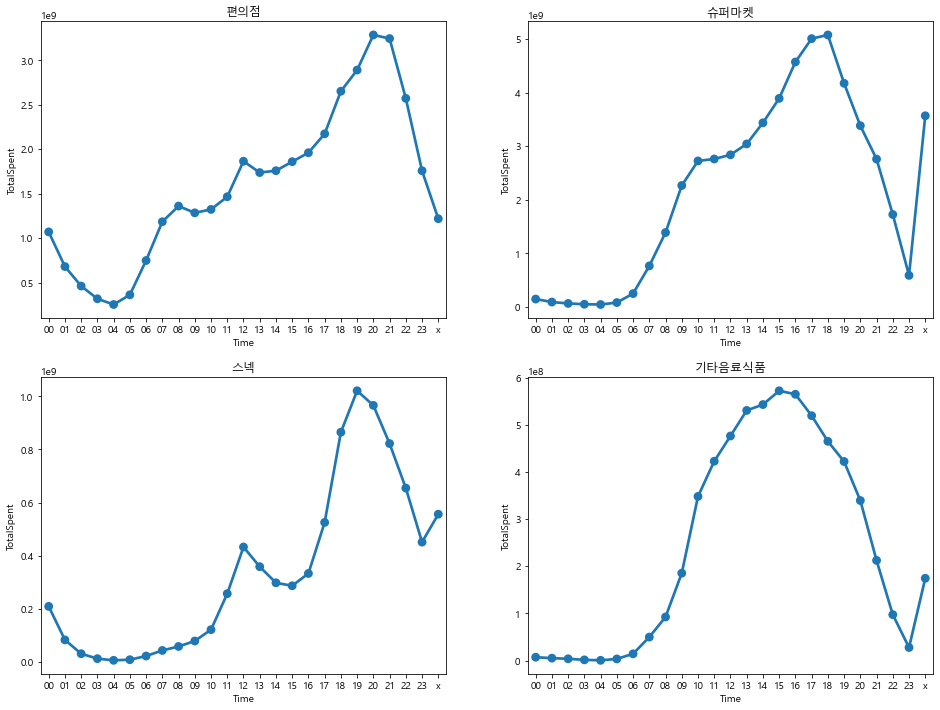

In [25]:
# 식음료 판매 업종 4가지의 시간대별 총 사용 금액과 건수

fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(2, 2, 1)
ax1 = sns.pointplot(x='Time', y='TotalSpent', data=jeju_all[(jeju_all['Type'] == '편의점')].groupby(['Type', 'Time'])['TotalSpent'].sum().reset_index())
ax1.set_title('편의점')
ax2 = fig.add_subplot(2, 2, 2)
ax2 = sns.pointplot(x='Time', y='TotalSpent', data=jeju_all[(jeju_all['Type'] == '슈퍼마켓')].groupby(['Type', 'Time'])['TotalSpent'].sum().reset_index())
ax2.set_title('슈퍼마켓')
ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.pointplot(x='Time', y='TotalSpent', data=jeju_all[(jeju_all['Type'] == '스넥')].groupby(['Type', 'Time'])['TotalSpent'].sum().reset_index())
ax3.set_title('스넥')
ax4 = fig.add_subplot(2, 2, 4)
ax4 = sns.pointplot(x='Time', y='TotalSpent', data=jeju_all[(jeju_all['Type'] == '기타음료식품')].groupby(['Type', 'Time'])['TotalSpent'].sum().reset_index())
ax4.set_title('기타음료식품')
plt.show()

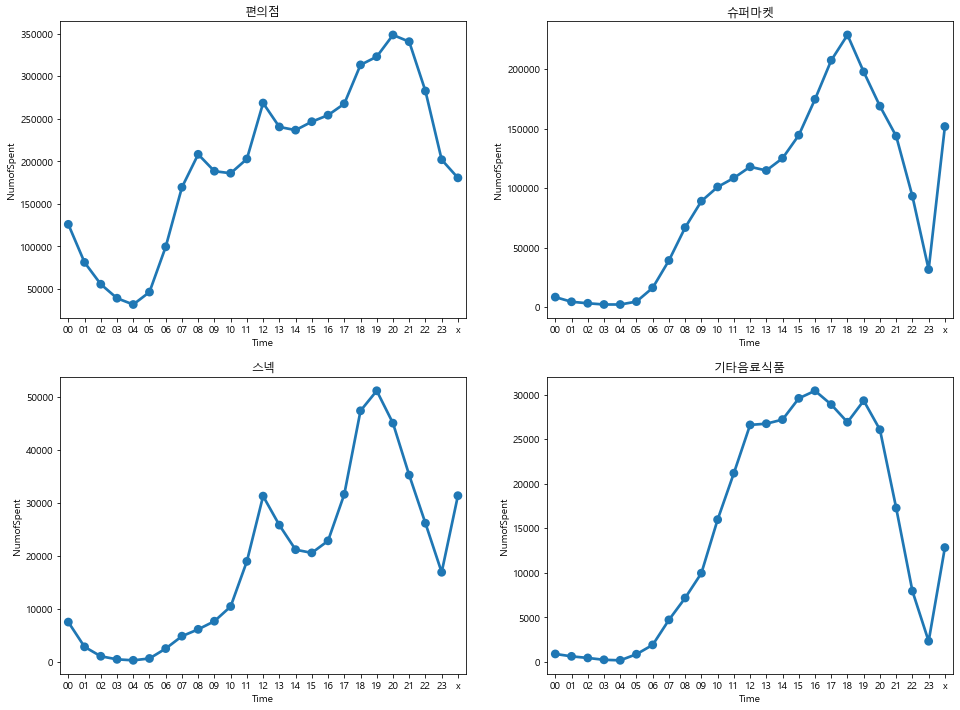

In [26]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(2, 2, 1)
ax1 = sns.pointplot(x='Time', y='NumofSpent', data=jeju_all[(jeju_all['Type'] == '편의점')].groupby(['Type', 'Time'])['NumofSpent'].sum().reset_index())
ax1.set_title('편의점')
ax2 = fig.add_subplot(2, 2, 2)
ax2 = sns.pointplot(x='Time', y='NumofSpent', data=jeju_all[(jeju_all['Type'] == '슈퍼마켓')].groupby(['Type', 'Time'])['NumofSpent'].sum().reset_index())
ax2.set_title('슈퍼마켓')
ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.pointplot(x='Time', y='NumofSpent', data=jeju_all[(jeju_all['Type'] == '스넥')].groupby(['Type', 'Time'])['NumofSpent'].sum().reset_index())
ax3.set_title('스넥')
ax4 = fig.add_subplot(2, 2, 4)
ax4 = sns.pointplot(x='Time', y='NumofSpent', data=jeju_all[(jeju_all['Type'] == '기타음료식품')].groupby(['Type', 'Time'])['NumofSpent'].sum().reset_index())
ax4.set_title('기타음료식품')
plt.show()

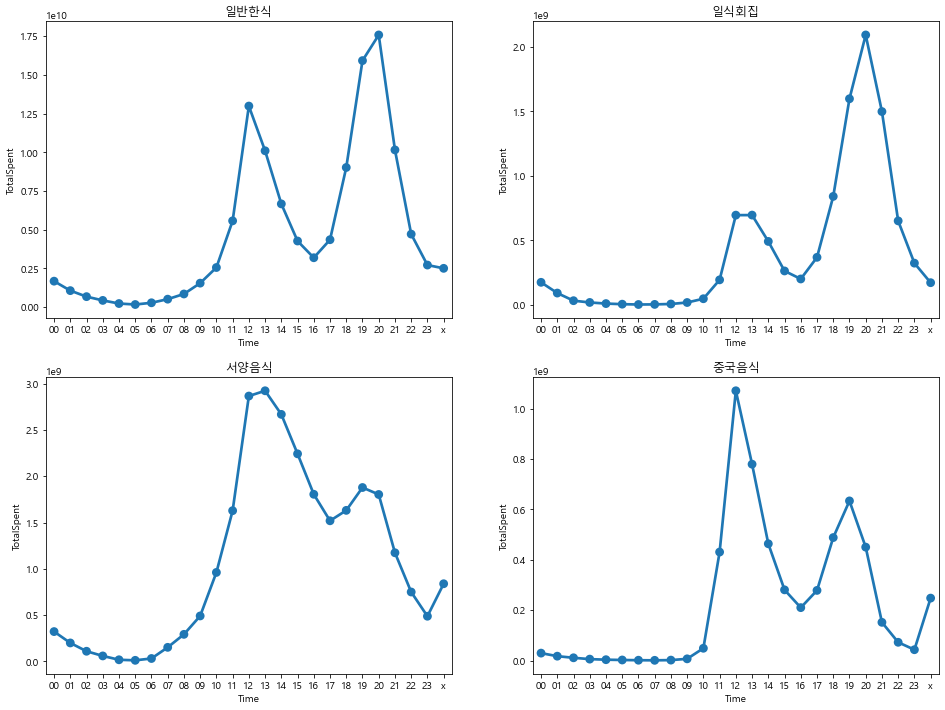

In [27]:
# 음식 종류로 분류된 업종 4가지의 시간대별 총 사용 금액과 건수

fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(2, 2, 1)
ax1 = sns.pointplot(x='Time', y='TotalSpent', data=jeju_all[(jeju_all['Type'] == '일반한식')].groupby(['Type', 'Time'])['TotalSpent'].sum().reset_index())
ax1.set_title('일반한식')
ax2 = fig.add_subplot(2, 2, 2)
ax2 = sns.pointplot(x='Time', y='TotalSpent', data=jeju_all[(jeju_all['Type'] == '일식회집')].groupby(['Type', 'Time'])['TotalSpent'].sum().reset_index())
ax2.set_title('일식회집')
ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.pointplot(x='Time', y='TotalSpent', data=jeju_all[(jeju_all['Type'] == '서양음식')].groupby(['Type', 'Time'])['TotalSpent'].sum().reset_index())
ax3.set_title('서양음식')
ax4 = fig.add_subplot(2, 2, 4)
ax4 = sns.pointplot(x='Time', y='TotalSpent', data=jeju_all[(jeju_all['Type'] == '중국음식')].groupby(['Type', 'Time'])['TotalSpent'].sum().reset_index())
ax4.set_title('중국음식')
plt.show()

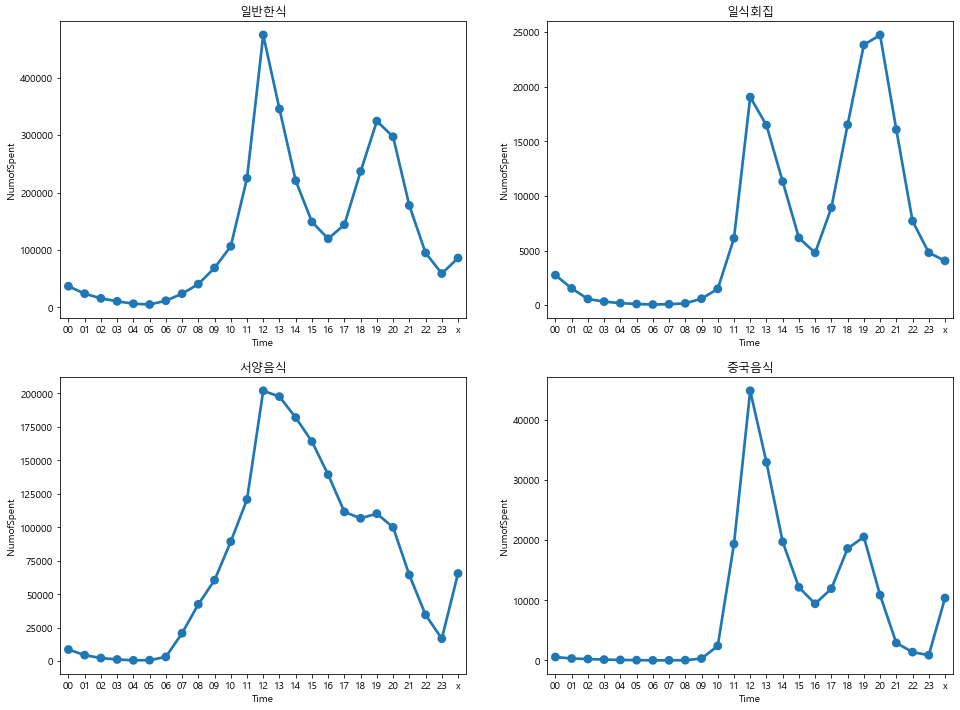

In [28]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(2, 2, 1)
ax1 = sns.pointplot(x='Time', y='NumofSpent', data=jeju_all[(jeju_all['Type'] == '일반한식')].groupby(['Type', 'Time'])['NumofSpent'].sum().reset_index())
ax1.set_title('일반한식')
ax2 = fig.add_subplot(2, 2, 2)
ax2 = sns.pointplot(x='Time', y='NumofSpent', data=jeju_all[(jeju_all['Type'] == '일식회집')].groupby(['Type', 'Time'])['NumofSpent'].sum().reset_index())
ax2.set_title('일식회집')
ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.pointplot(x='Time', y='NumofSpent', data=jeju_all[(jeju_all['Type'] == '서양음식')].groupby(['Type', 'Time'])['NumofSpent'].sum().reset_index())
ax3.set_title('서양음식')
ax4 = fig.add_subplot(2, 2, 4)
ax4 = sns.pointplot(x='Time', y='NumofSpent', data=jeju_all[(jeju_all['Type'] == '중국음식')].groupby(['Type', 'Time'])['NumofSpent'].sum().reset_index())
ax4.set_title('중국음식')
plt.show()

#### 먹거리 업종의 시간대별 이용 현황
- 전체적으로 보았을 때 총 이용 건수가 많다고 하더라도 총 사용 금액이 똑같이 높아지지 않는 것으로 보임
- 유사한 시간대에 소비가 이루어지지만 '기타음료식품'의 경우 뚜렷하게 많이 이용되고 있는 시간대가 있는 것을 보여줌 (11시~20시)

# 2. 재난지원금 분석 - 포인트 (기간별)

<AxesSubplot:xlabel='YM', ylabel='DisSpent'>

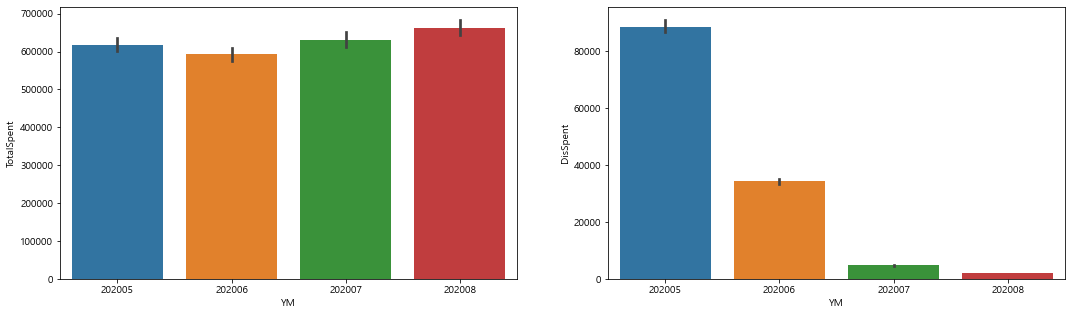

In [18]:
# 월별 총 사용금액 / 월별 재난지원금 총 사용금액 

figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18,5)


sns.barplot(data=jeju_all, x="YM", y="TotalSpent", ax=ax1)
sns.barplot(data=jeju_all, x="YM", y="DisSpent", ax=ax2)

#### 대부분의 재난지원금은 5월에 사용되었음을 알 수 있음 

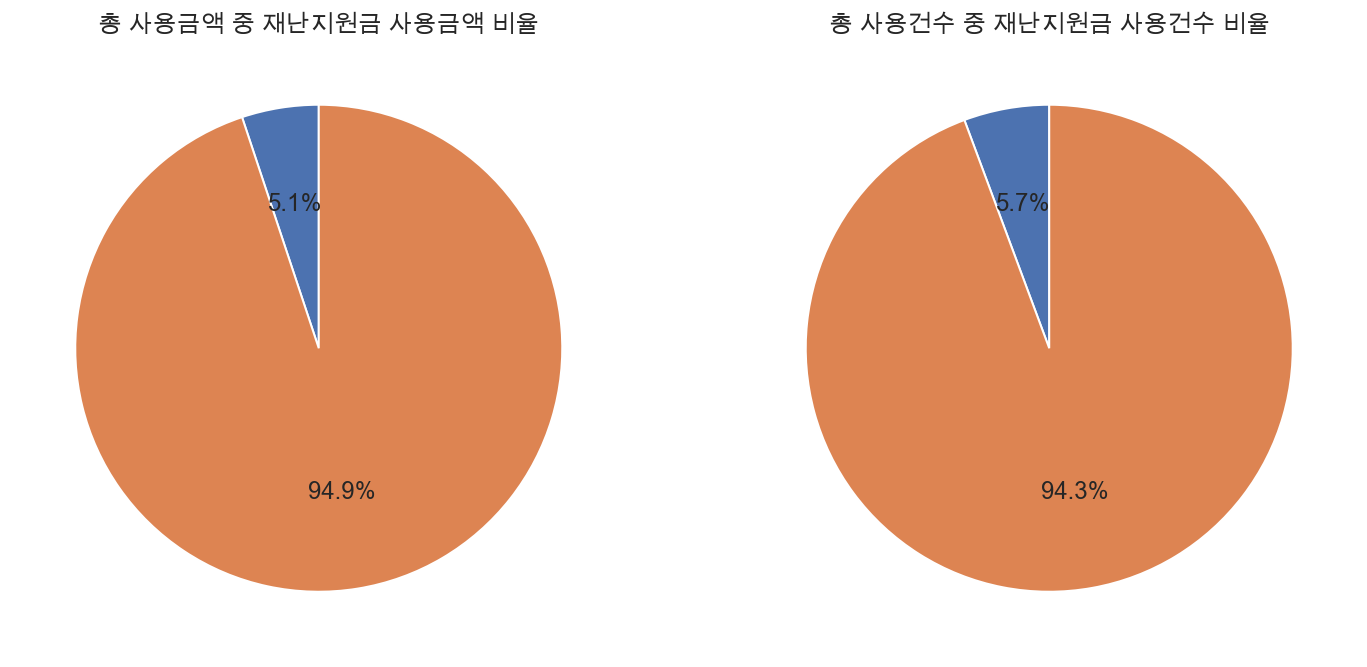

In [43]:
# 전체 기간의 소비 대비 재난지원금 사용비율 
fig = plt.figure(figsize=[12, 10])

title = "총 사용금액 중 재난지원금 사용금액 비율"
sizes = [jeju_all.DisSpent.mean()*100/jeju_all.TotalSpent.mean(), 100-(jeju_all.DisSpent.mean()*100/jeju_all.TotalSpent.mean())] 
ax1 = fig.add_subplot(1, 2, 1)
ax1 = plt.pie(sizes, autopct='%1.1f%%', startangle=90)
ax1 = plt.title(title)

title = "총 사용건수 중 재난지원금 사용건수 비율"
sizes = [jeju_all.NumofDisSpent.mean()*100/jeju_all.NumofSpent.mean(), 100-(jeju_all.NumofDisSpent.mean()*100/jeju_all.NumofSpent.mean())] 
ax2 = fig.add_subplot(1, 2, 2)
ax2 = plt.pie(sizes, autopct='%1.1f%%', startangle=90)
ax2 = plt.title(title)

plt.show()

In [44]:
jeju_total = jeju_all.groupby('YM')['TotalSpent'].sum()
jeju_dis = jeju_all.groupby('YM')['DisSpent'].sum()
jeju_month = jeju_total/jeju_all.TotalSpent.sum()
jeju_p = jeju_dis/jeju_total

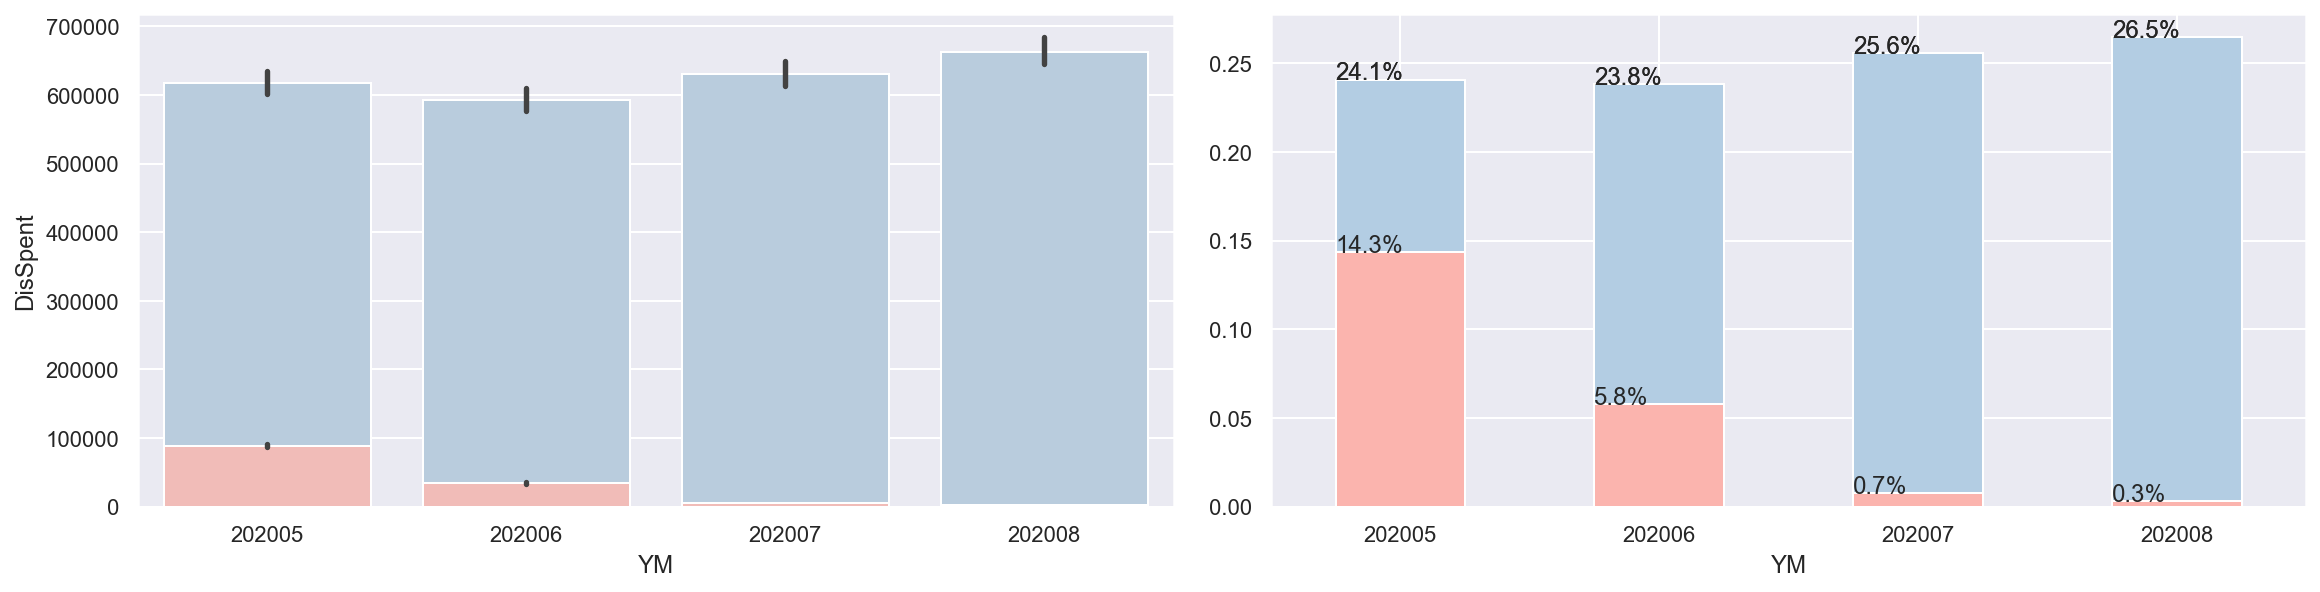

In [45]:
# 월별 총사용금액 - 총사용금액 대비 재난지원금 확인 

figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
figure.set_size_inches(16,4)

sns.barplot(x='YM', y ='TotalSpent', data=jeju_all, color='#b3cde3', ax=ax1)
sns.barplot(x='YM', y ='DisSpent', data=jeju_all, color='#fbb4ae', ax=ax1)


# 총 사용금액의 월별 사용비율 
# 재난지원금 월별 사용 비율
ax2 = jeju_month.plot.bar(x='YM', y='0', rot=0, color='#b3cde3')
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height())
    x = p.get_x()
    y = p.get_y() + p.get_height()
    ax2.annotate(percentage, (x, y))
ax2 = jeju_p.plot.bar(x='YM', y='0', rot=0, color='#fbb4ae')
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height())
    x = p.get_x()
    y = p.get_y() + p.get_height()
    ax2.annotate(percentage, (x, y))

#### 5월 총 사용금액이 다른 월의 총사용금액과 비슷한 이유는 재난지원금의 사용금액이 포함되어서임 
###### (5월 관광객(33,347),  8월 관광객(74,795) 관광객이 2배가 넘음에도 불구하고 5,8월 총 사용금액이 거의 비슷함)
#### 1) 5월과 재난지원금 사용금액이 거의 없는 8월의 소비를 분석해보면 
#### 2) 어느 업종/지역/규모업종이 재난지원금이 사용되었는지 알 수 있음 
#### 3) 어느 업종/지역/규모업종에 재난지원금이 사용되었는지에 따라 지원 정책의 효과를 본 업종/지역/규모업종에 대한 결론을 확인할 수 있음 

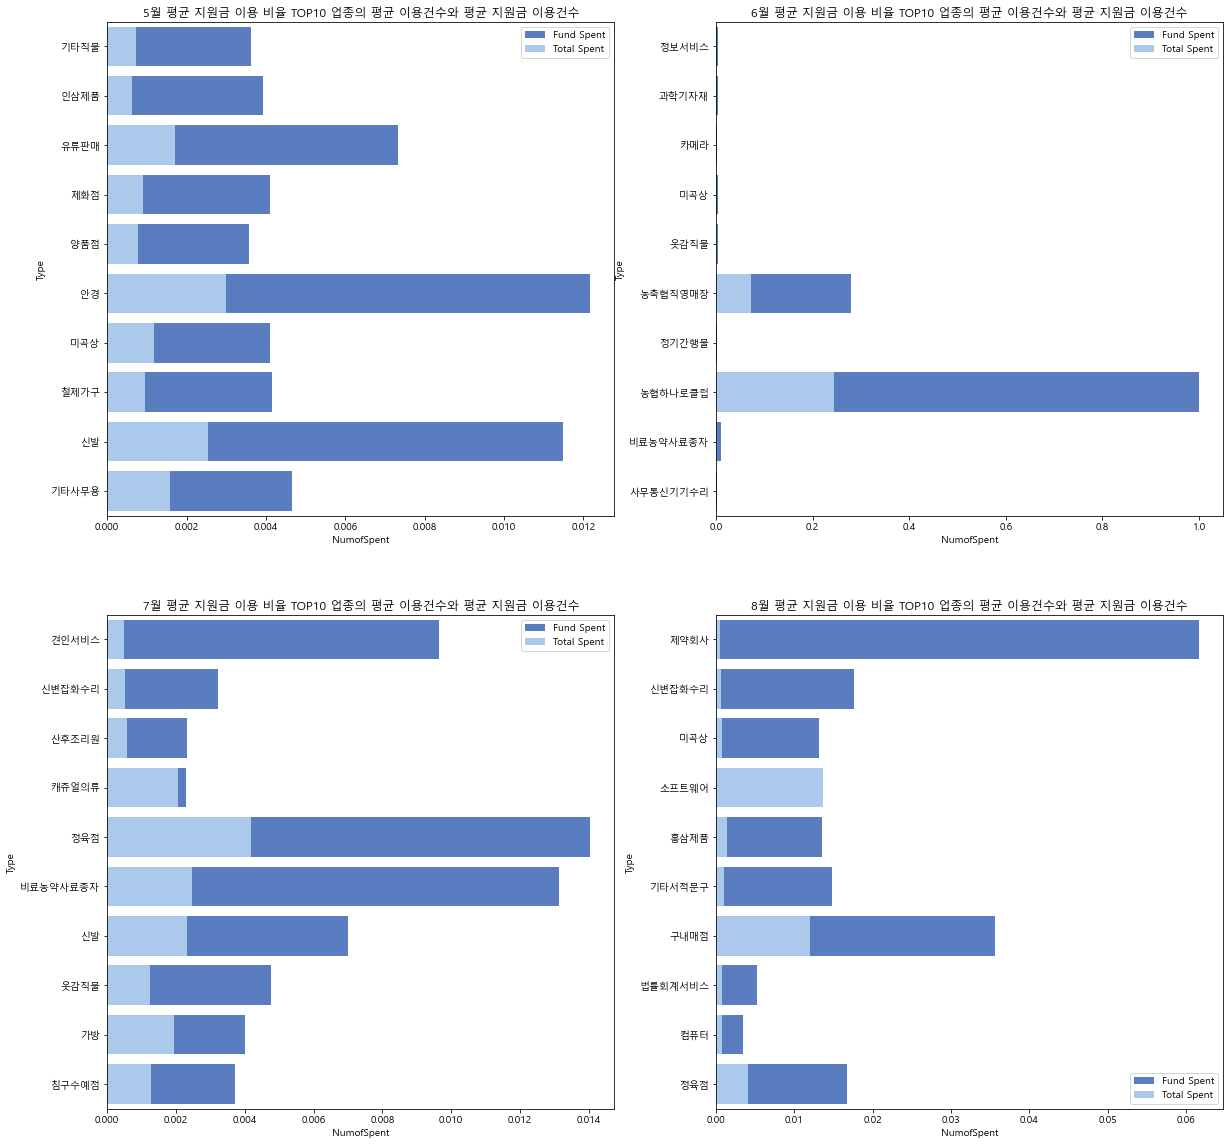

In [29]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(2, 2, 1)
ax1 = sns.set_color_codes('muted')
ax1 = sns.barplot(x='NumofDisSpent', y='Type', data=norm_jeju_type_5.nlargest(10 ,'dis/tot'), label='Fund Spent', color='b')
ax1 = sns.set_color_codes('pastel')
ax1 = sns.barplot(x='NumofSpent', y='Type', data=norm_jeju_type_5.nlargest(10 ,'dis/tot'), label='Total Spent', color='b')
ax1.legend(loc='best', frameon=True)
ax1.set_title('5월 평균 지원금 이용 비율 TOP10 업종의 평균 이용건수와 평균 지원금 이용건수')

ax2 = fig.add_subplot(2, 2, 2)
ax2 = sns.set_color_codes('muted')
ax2 = sns.barplot(x='NumofDisSpent', y='Type', data=norm_jeju_type_6.nlargest(10 ,'dis/tot'), label='Fund Spent', color='b')
ax2 = sns.set_color_codes('pastel')
ax2 = sns.barplot(x='NumofSpent', y='Type', data=norm_jeju_type_6.nlargest(10 ,'dis/tot'), label='Total Spent', color='b')
ax2.legend(loc='best', frameon=True)
ax2.set_title('6월 평균 지원금 이용 비율 TOP10 업종의 평균 이용건수와 평균 지원금 이용건수')

ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.set_color_codes('muted')
ax3 = sns.barplot(x='NumofDisSpent', y='Type', data=norm_jeju_type_7.nlargest(10 ,'dis/tot'), label='Fund Spent', color='b')
ax3 = sns.set_color_codes('pastel')
ax3 = sns.barplot(x='NumofSpent', y='Type', data=norm_jeju_type_7.nlargest(10 ,'dis/tot'), label='Total Spent', color='b')
ax3.legend(loc='best', frameon=True)
ax3.set_title('7월 평균 지원금 이용 비율 TOP10 업종의 평균 이용건수와 평균 지원금 이용건수')

ax4 = fig.add_subplot(2, 2, 4)
ax4 = sns.set_color_codes('muted')
ax4 = sns.barplot(x='NumofDisSpent', y='Type', data=norm_jeju_type_8.nlargest(10 ,'dis/tot'), label='Fund Spent', color='b')
ax4 = sns.set_color_codes('pastel')
ax4 = sns.barplot(x='NumofSpent', y='Type', data=norm_jeju_type_8.nlargest(10 ,'dis/tot'), label='Total Spent', color='b')
ax4.legend(loc='best', frameon=True)
ax4.set_title('8월 평균 지원금 이용 비율 TOP10 업종의 평균 이용건수와 평균 지원금 이용건수')
plt.show()

#### 월별로 평균 재난지원금 이용 비율이 높은 TOP10 업종은 안경, 농협하나로클럽, 정육점, 제약회사로 다양한 업종규모와 업종에 재난지원금이 사용되었음. 재난지원금 평균 이용 건수가 총 평균 건수가 더 높다는 것을 알 수 있음

# 3. 재난지원금 - 업종별 
1. 8월 대비 5월에 사용이 더 많은 업종은 재난 지원금 소비 촉진의 결과일 것  

In [71]:
# 5월 8월의 업종별 사용금액 (상위 / 하위)

# 5월 8월 데이터 분리하기 
cond1 = jeju_all['YM'] == 202005
cond2 = jeju_all['YM'] == 202008
jeju_may_aug = jeju_all[cond1|cond2]

jeju_may_aug.head()

,OBJECTID,Field1,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,lon,lat,lon_lat,dong,Category,Time_cut
0,1,1,202005,제주특별자치도,제주시,영세,일반한식,00,363000,66500,10,2,877005.98340,1479766.07300,126.17889362710162,33.30231529076243,126.17889362710162_33.30231529076243,한경면,외식/주점,심야
1,4904,4904,202005,제주특별자치도,제주시,영세,일반한식,01,86500,0,3,0,877005.98340,1479766.07300,126.17889362710162,33.30231529076243,126.17889362710162_33.30231529076243,한경면,외식/주점,심야
2,8569,8569,202005,제주특별자치도,제주시,영세,일반한식,02,208000,0,5,0,877005.98340,1479766.07300,126.17889362710162,33.30231529076243,126.17889362710162_33.30231529076243,한경면,외식/주점,새벽
3,11270,11270,202005,제주특별자치도,제주시,영세,일반한식,03,18000,0,1,0,877005.98340,1479766.07300,126.17889362710162,33.30231529076243,126.17889362710162_33.30231529076243,한경면,외식/주점,새벽
4,19122,19122,202005,제주특별자치도,제주시,중소,한의원,07,4800,0,2,0,877005.98340,1479766.07300,126.17889362710162,33.30231529076243,126.17889362710162_33.30231529076243,한경면,의료,오전


<AxesSubplot:xlabel='Category', ylabel='TotalSpent'>

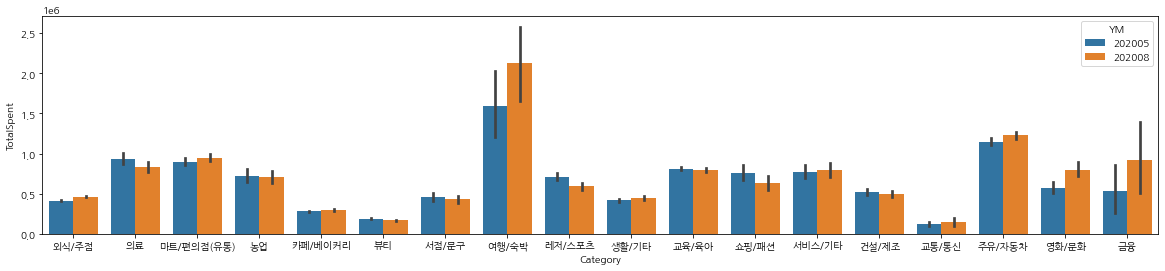

In [72]:
f, ax = plt.subplots(figsize=(20,4))
sns.barplot(x='Category', y ='TotalSpent', data=jeju_may_aug, hue='YM')

#### 2. 의료, 레저/스포츠, 교육/육아, 쇼핑/패션 분야가 재난지원금이 없는 8월 대비 높음 
#### 3. 재난지원금으로 소비 촉진이 일어난 업종일 것

# 4. 재난지원금 사용 분석 - 지역별 

1. 지역별-월별 총 사용금액 중 5월 사용이 많은 지역 > 재난지원금에 의한 사용 영향이 있을 것 
2. 5월 총 사용금액 > 8월 총 사용금액에 해당하는 지역을 분석 

##### 제주시 행정구역을 읍면동으로 구분하되 제주시의 시내동은 제주시로 통일함 
##### 서귀포시 행정구역을 읍면동으로 구분하되 서귀포시의 시내동은 서귀포시로 통일함 

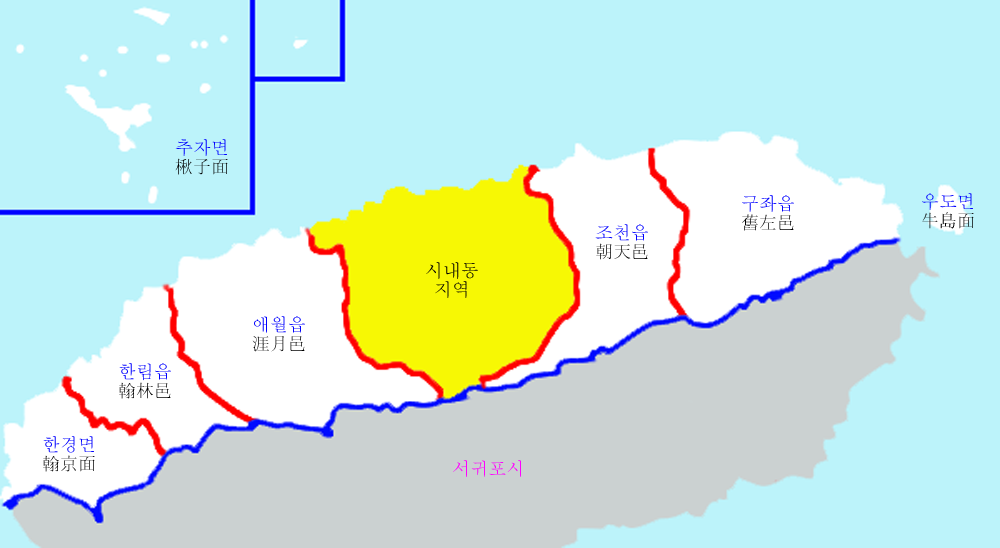

In [73]:
# 제주시 행정구역 이미지 (출처 : 위키백과)

from IPython.display import Image

Image('Jeju_city.png')

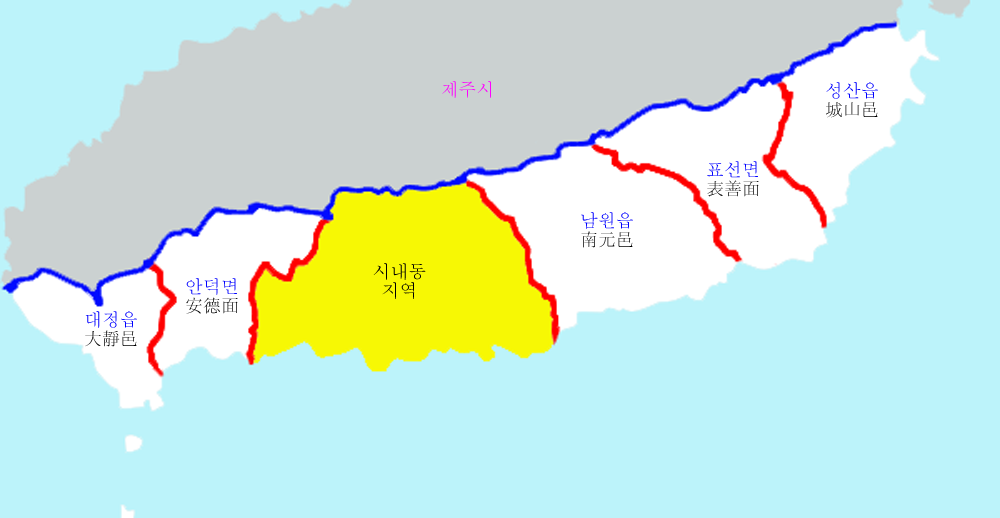

In [74]:
Image('Seogwipo_city.png')

In [75]:
# 제주시 --동 > 제주시로 통일
cond1 = jeju_all['SIGUNGU'] == '제주시'
cond2 = jeju_all['dong'].str.contains('동')
jeju_all['dong_cat'] = np.where(jeju_all['dong'].str.contains('동'),jeju_all['SIGUNGU'], jeju_all['dong'])

# 서귀포시 --동 > 서귀포시로 통일
cond1 = jeju_all['SIGUNGU'] == '서귀포시'
cond2 = jeju_all['dong'].str.contains('동')
jeju_all['dong_cat'] = np.where(jeju_all['dong'].str.contains('동'),jeju_all['SIGUNGU'], jeju_all['dong'])

jeju_all.tail(3)

,OBJECTID,Field1,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,lon,lat,lon_lat,dong,Category,Time_cut,dong_cat
280082,278935,278935,202008,제주특별자치도,서귀포시,영세,예체능학원,x,110000,0,1,0,921003.98200,1476177.84050,126.65174159048293,33.27407883370635,126.65174159048293_33.27407883370635,남원읍,교육/육아,무승인거래,남원읍
280083,279538,279538,202008,제주특별자치도,서귀포시,영세,기타가구,x,50000,0,1,0,937500.16740,1486052.75280,126.82818252032293,33.36422597166203,126.82818252032293_33.36422597166203,성산읍,생활/기타,무승인거래,성산읍
280084,279785,279785,202008,제주특별자치도,제주시,영세,기타숙박업,x,17470,0,2,0,941114.05310,1503713.22230,126.86586853032782,33.52371304945294,126.86586853032782_33.52371304945294,구좌읍,여행/숙박,무승인거래,구좌읍


<AxesSubplot:xlabel='dong_cat', ylabel='TotalSpent'>

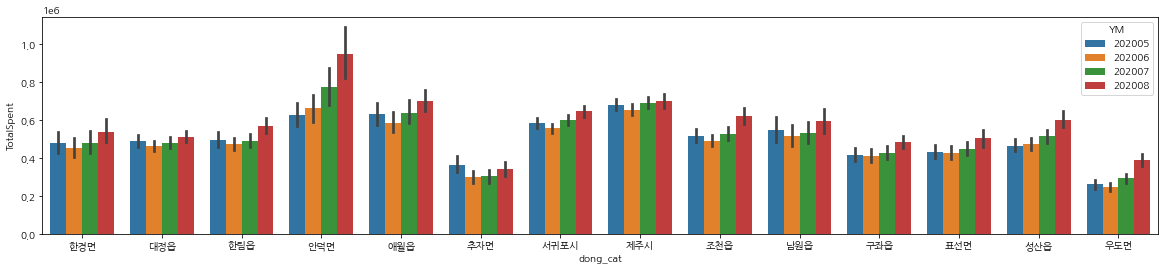

In [76]:
# 지역별-월별 총사용금액 
f, ax = plt.subplots(figsize=(20,4))
sns.barplot(x='dong_cat', y ='TotalSpent', data=jeju_all, hue='YM')

#### 총사용금액 5월 8월 비교 읍면동별 구분 
- 재난지원금이 20% 이상 차지하는 5월
- 재난지원금이 없었다면 8월 총사용금액에 비해 낮아야함 
- 재난지원금 사용으로 8월 총 사용금액과 비슷해진 지역의 경우, 재난지원금의 영향으로 소비가 촉진된 지역임 


#### 제주시와 추자면의 경우 5월과 8월의 사용금액이 거의 비슷함 
- 제주시 : 제주도 핵심 상권 지역으로 대부분의 상점, 편의시설 등이 몰려있음 
- 추자면 : 제주도 북부에 멀리 떨어진 도서 지역으로 물리적으로 재난지원금을 다른 지역에서 소비하기 어려웠을 것임 

<AxesSubplot:xlabel='SIGUNGU', ylabel='TotalSpent'>

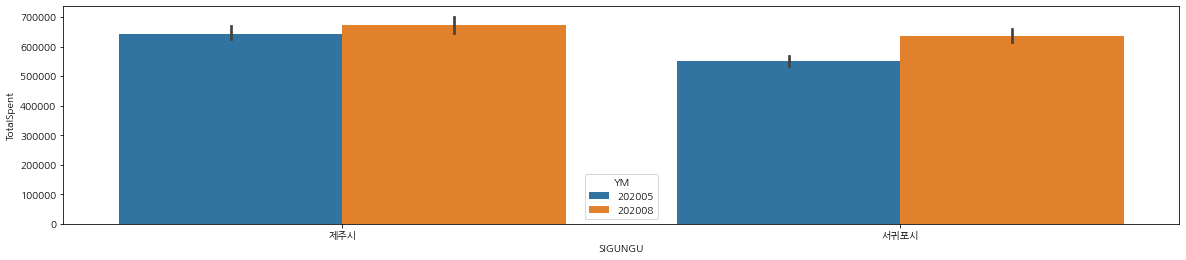

In [77]:
f, ax = plt.subplots(figsize=(20,4))
sns.barplot(x='SIGUNGU', y ='TotalSpent', data=jeju_may_aug, hue='YM')

#### 총사용금액 5월 8월 시별 구분 
- 제주시가 서귀포시에 비해 재난지원금의 상대적 효과가 큼  

# 5. 재난지원금 사용분석 - 업종규모별 

<AxesSubplot:xlabel='FranClass', ylabel='TotalSpent'>

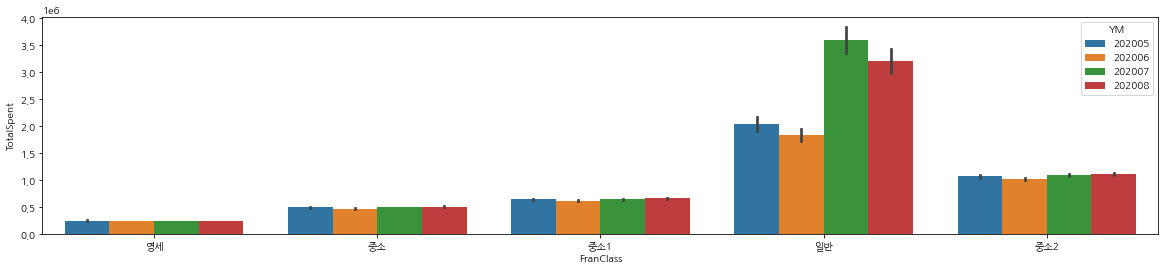

In [78]:
# 재난지원금 어느 상업규모에 도움이 되었는지 
f, ax = plt.subplots(figsize=(20,4))
sns.barplot(x='FranClass', y ='TotalSpent', data=jeju_all, hue='YM')

#### 일반 업종은 재난지원금 효과 낮음 그외 효과 있었음 
- 일반 업종의 대부분은 면세점, 골프장 등의 재난지원금 사용불가 업종이 많았음 
- 아래 그래프를 보면 일반업종을 제외하고 모두 비슷한 소비형태와 총 사용금액을 볼 수 있다.

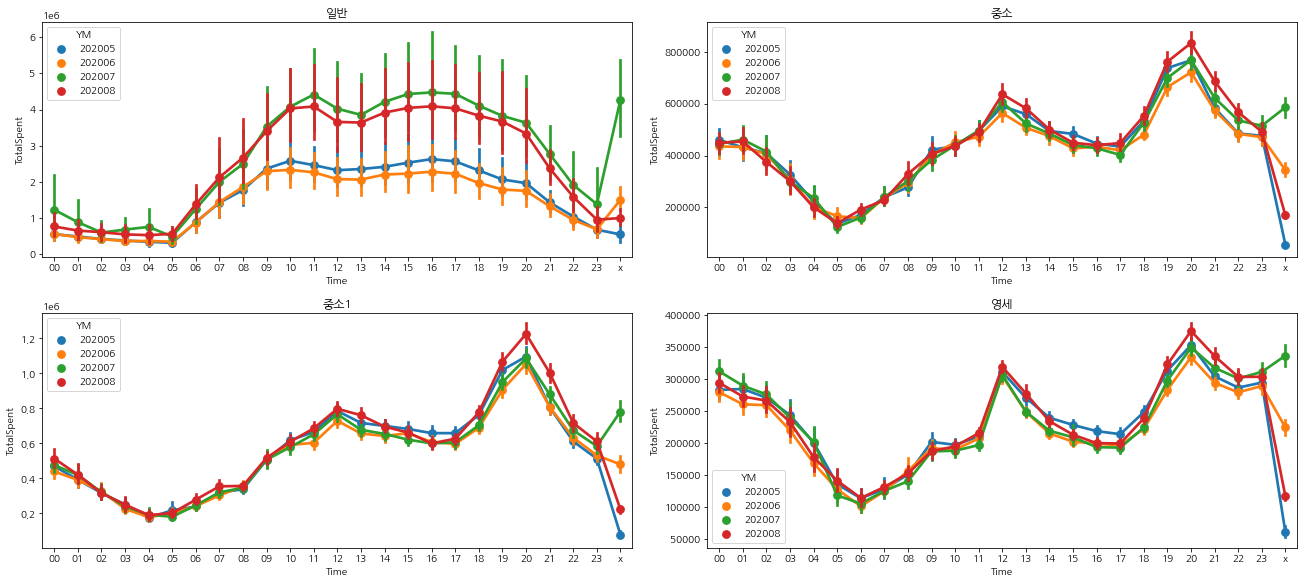

In [84]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
figure.set_size_inches(18,8)

sns.pointplot(data=jeju_all[jeju_all['FranClass']=='일반'], x="Time", y="TotalSpent", hue='YM',ax=ax1, order = ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21', '22', '23', 'x'])
sns.pointplot(data=jeju_all[jeju_all['FranClass']=='중소'], x="Time", y="TotalSpent",hue='YM', ax=ax2, order = ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21', '22', '23', 'x'])
sns.pointplot(data=jeju_all[jeju_all['FranClass']=='중소1'], x="Time", y="TotalSpent",hue='YM', ax=ax3, order = ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21', '22', '23', 'x'])
sns.pointplot(data=jeju_all[jeju_all['FranClass']=='영세'], x="Time", y="TotalSpent",hue='YM', ax=ax4, order = ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21', '22', '23', 'x'])
ax1.set_title("일반")
ax2.set_title("중소")
ax3.set_title("중소1")
ax4.set_title("영세")

plt.show();

#### 일반업종 
- 일반 업종의 경우 7,8월 대비 5,6월의 소비가 유독 낮음
- 5,6월의 경우 재난지원금 사용이 불가하여 소비 낮음
- 7,8월의 경우 5,6월 대비 관광객의 유입이 많았음
- 관광 관련 업종인 면세점, 골프경기장, 특급호텔 등의 소비의 증가로 7,8월 일반 업종의 소비 증대되었을 것 

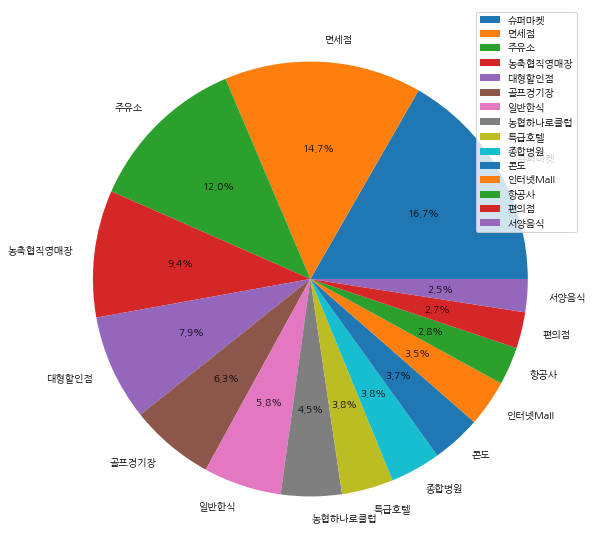

In [85]:
# 총 사용금액 중 일반 업종 규모에 해당하는 업종타입 확인 
plt.figure(figsize=(10,10))

jeju_class_norm = jeju_all[jeju_all['FranClass'] == '일반']
df_norm = jeju_class_norm.groupby('Type').sum()
df_norm = df_norm.sort_values(['TotalSpent'], ascending= [False]).head(15)

data = df_norm['TotalSpent'].values[:15]
cat = df_norm['TotalSpent'].index[:15]

plt.pie(data, labels=cat, autopct='%0.1f%%')
plt.legend(cat)

plt.show()

#### 재난지원금 사용불가 업종 : 
- 대형마트, 골프경기장, 면세점, (기업형)슈퍼마켓, 온라인전자 업종에서 사용 불가 
- 일반 업종규모의 경우 상위 대부분이 재난지원금 사용 불가 업종이었음 

# 결론 
- 재난지원금의 사용의 경우 특정 지역, 업종에 따라 사용이 되었음 
- 5월의 전체적인 소비를 촉진한 것은 맞지만 일부 지역과 업종에 한하여 촉진되어 전체적인 소비 촉진 정책으로 보기 어렵다 